# Preliminary Evidence and Experimental Design for Archetype Manuscript

In [54]:
# from plotly.offline import init_notebook_mode, iplot
#from plotly.graph_objs import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
#import plotly
import plotly.graph_objs as go
#plotly.tools.set_credentials_file(username='sfmaddox42', api_key='SOJVGjBN7E7orxpBFLlo')
import seaborn as sns
import scanpy as sc
import scvelo as scv

In [3]:
import os.path as op
indir='/Users/smgroves/Dropbox (VU Basic Sciences)/SCLC/RNAseq-analysis/Drug_response'


In [4]:
outdir = '/Users/smgroves/Documents/pycharm_workspace/mazebox/mazebox/examples/notebooks/bulk/'

In [5]:
distances = pd.read_csv(op.join(outdir,"arc_space/distances.csv"), header = None).T
distances.columns = ['SCLC-Y', 'SCLC-P','SCLC-N','SCLC-A2','SCLC-A']
clines = pd.read_csv(op.join(outdir,"arc_space/combined_clusters_2020-05-27-MC copy.csv"), index_col = 0)
ordering = pd.read_csv(op.join(outdir,"arc_space/ordering.csv"), header = None).T
#change from MATLAB to python indexing
ordering = ordering-1
for c in ordering:
    ordering[f"order_{c}"] = clines.index[list(ordering[c])]
ordering.columns = [0,1,2,3,4, 'SCLC-Y','SCLC-P','SCLC-N','SCLC-A2','SCLC-A']
for c in distances:
    x = distances[c]
    x.index = ordering[c].values
    distances[c] = x.sort_index().values
distances.index = clines.index
pcs = pd.read_csv(op.join(outdir,"arc_space/pc.csv"), header = None)
pcs.index = clines.index
data = pd.read_csv(op.join(outdir,'arc_space/SCLC_combined_Minna_CCLE_batch_corrected_wo_lowgenes.csv'), header = 0, index_col=0)
data = data.T

In [6]:
adata = sc.read_h5ad('../../int/clines/adata06.h5ad')

## Goals and claims to substantiate

1. Generalists are poised to diversify and regenerate the specialist populations under different conditions, but are also stable (i.e. not just transition states) on their own
    1. How do cell lines like H82 maintain this heterogeneity? If you isolate generalists or specialists (based on markers from your scRNA-seq), do they regenerate the whole population?
    3. Hypothesis is that generalists can regenerate the heterogeneity whereas specialists would not
1. Traversing the continuum could be strictly linked to recalcitrant properties, or abilities to adapt to metastatic microenvironment, or become resistant to therapy
2. Vertices optimize cancer hallmarks 
3. Based on this plasticity analysis of RPM tumor cells, we conclude that MYC was capable of influencing the distribution of SCLC cell states by increasing CTrP in neuroendocrine specialists
4. SCLC is particularly plastic




## Archetype Space

Below we have used a PCA to visualize 120 bulk RNA-seq data from SCLC cell lines. Each principal component is associated with a cell type signature, and archetypes found by ParTI (Alon group) are enriched in different signatures. For example, A and A2 are neuronal, while A2 is more endocrine (secretory). By comparing these features of the cell lines (what the cells **are**, we can start to understand how the features are combined to figure out the function of each archetype-- what the cells **do**.)

In [7]:
arc = pd.read_csv(op.join(outdir, 'arc_space/arc_gene_space_no_lowgenes.csv'), header = None)
arc.columns = data.columns
arc = arc.T
pc_loadings = pd.read_csv(op.join(outdir, 'arc_space/pc_loadings.csv'), header = None)
pc_loadings.index = data.columns
arc_pc = pc_loadings.T.dot(arc.sub(data.mean().values, axis = 0))
arc_pc.columns = ['SCLC-Y','SCLC-P','SCLC-N','SCLC-A2','SCLC-A']
arc_pc = arc_pc[sorted(list(arc_pc.columns))]

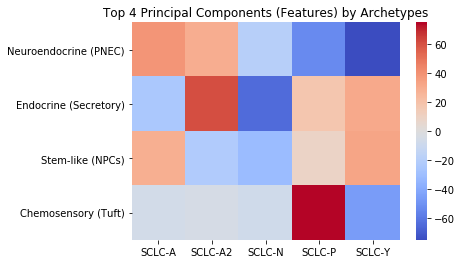

In [150]:
arc_hm = arc_pc.iloc[0:4]
arc_hm.index = ['Neuroendocrine (PNEC)','Endocrine (Secretory)','Stem-like (NPCs)', 'Chemosensory (Tuft)']
sns.heatmap(arc_hm, cmap='coolwarm', vmin = -75, vmax = 75,)
plt.title('Top 4 Principal Components (Features) by Archetypes')
plt.show()

PC1:
- (+) NE (PNECs)
- (-) Non-NE (Mesenchymal)

PC2:
- (+) Endocrine (Secretory)
- (-) Neuronal (Nervous system development)


PC3:
- (+) Stem-like (NPCs) or neural mesenchyme
- (-) Differentiated cell

PC4:
- (+) Chemosensory (tuft)
- (-) Migratory

In [9]:
# pc_loadings.sort_values(2, ascending=False).head(20)
#     print(i)

Archetype space with labels for only cell lines with scRNA-seq (as a side note, PCA from MatLab automatically mean-centers the data before transforming and finding archetypes):

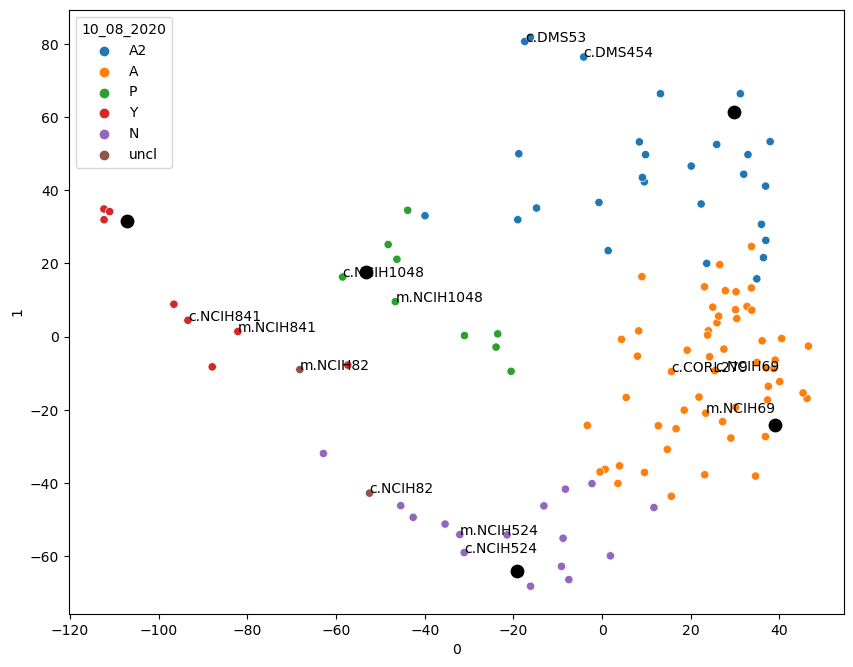

In [153]:
pcs_to_plot = [0,1]
plt.figure(figsize = (10,8), dpi = 100)
sns.scatterplot(pcs[pcs_to_plot[0]],pcs[pcs_to_plot[1]], hue = clines['10_08_2020'])
plt.scatter(arc_pc.iloc[pcs_to_plot[0]],arc_pc.iloc[pcs_to_plot[1]], color = 'black', s = 80)
for (x,y, label) in zip(pcs[pcs_to_plot[0]],pcs[pcs_to_plot[1]],clines.index):
    try:
        if label.split('.')[1] in adata.obs['cline'].cat.categories:
            plt.text(x,y,label)
        elif label.split('.NCI')[1] in adata.obs['cline'].cat.categories:
            plt.text(x,y,label)
    except IndexError: pass


Archetype space with all cell lines labeled, for reference:

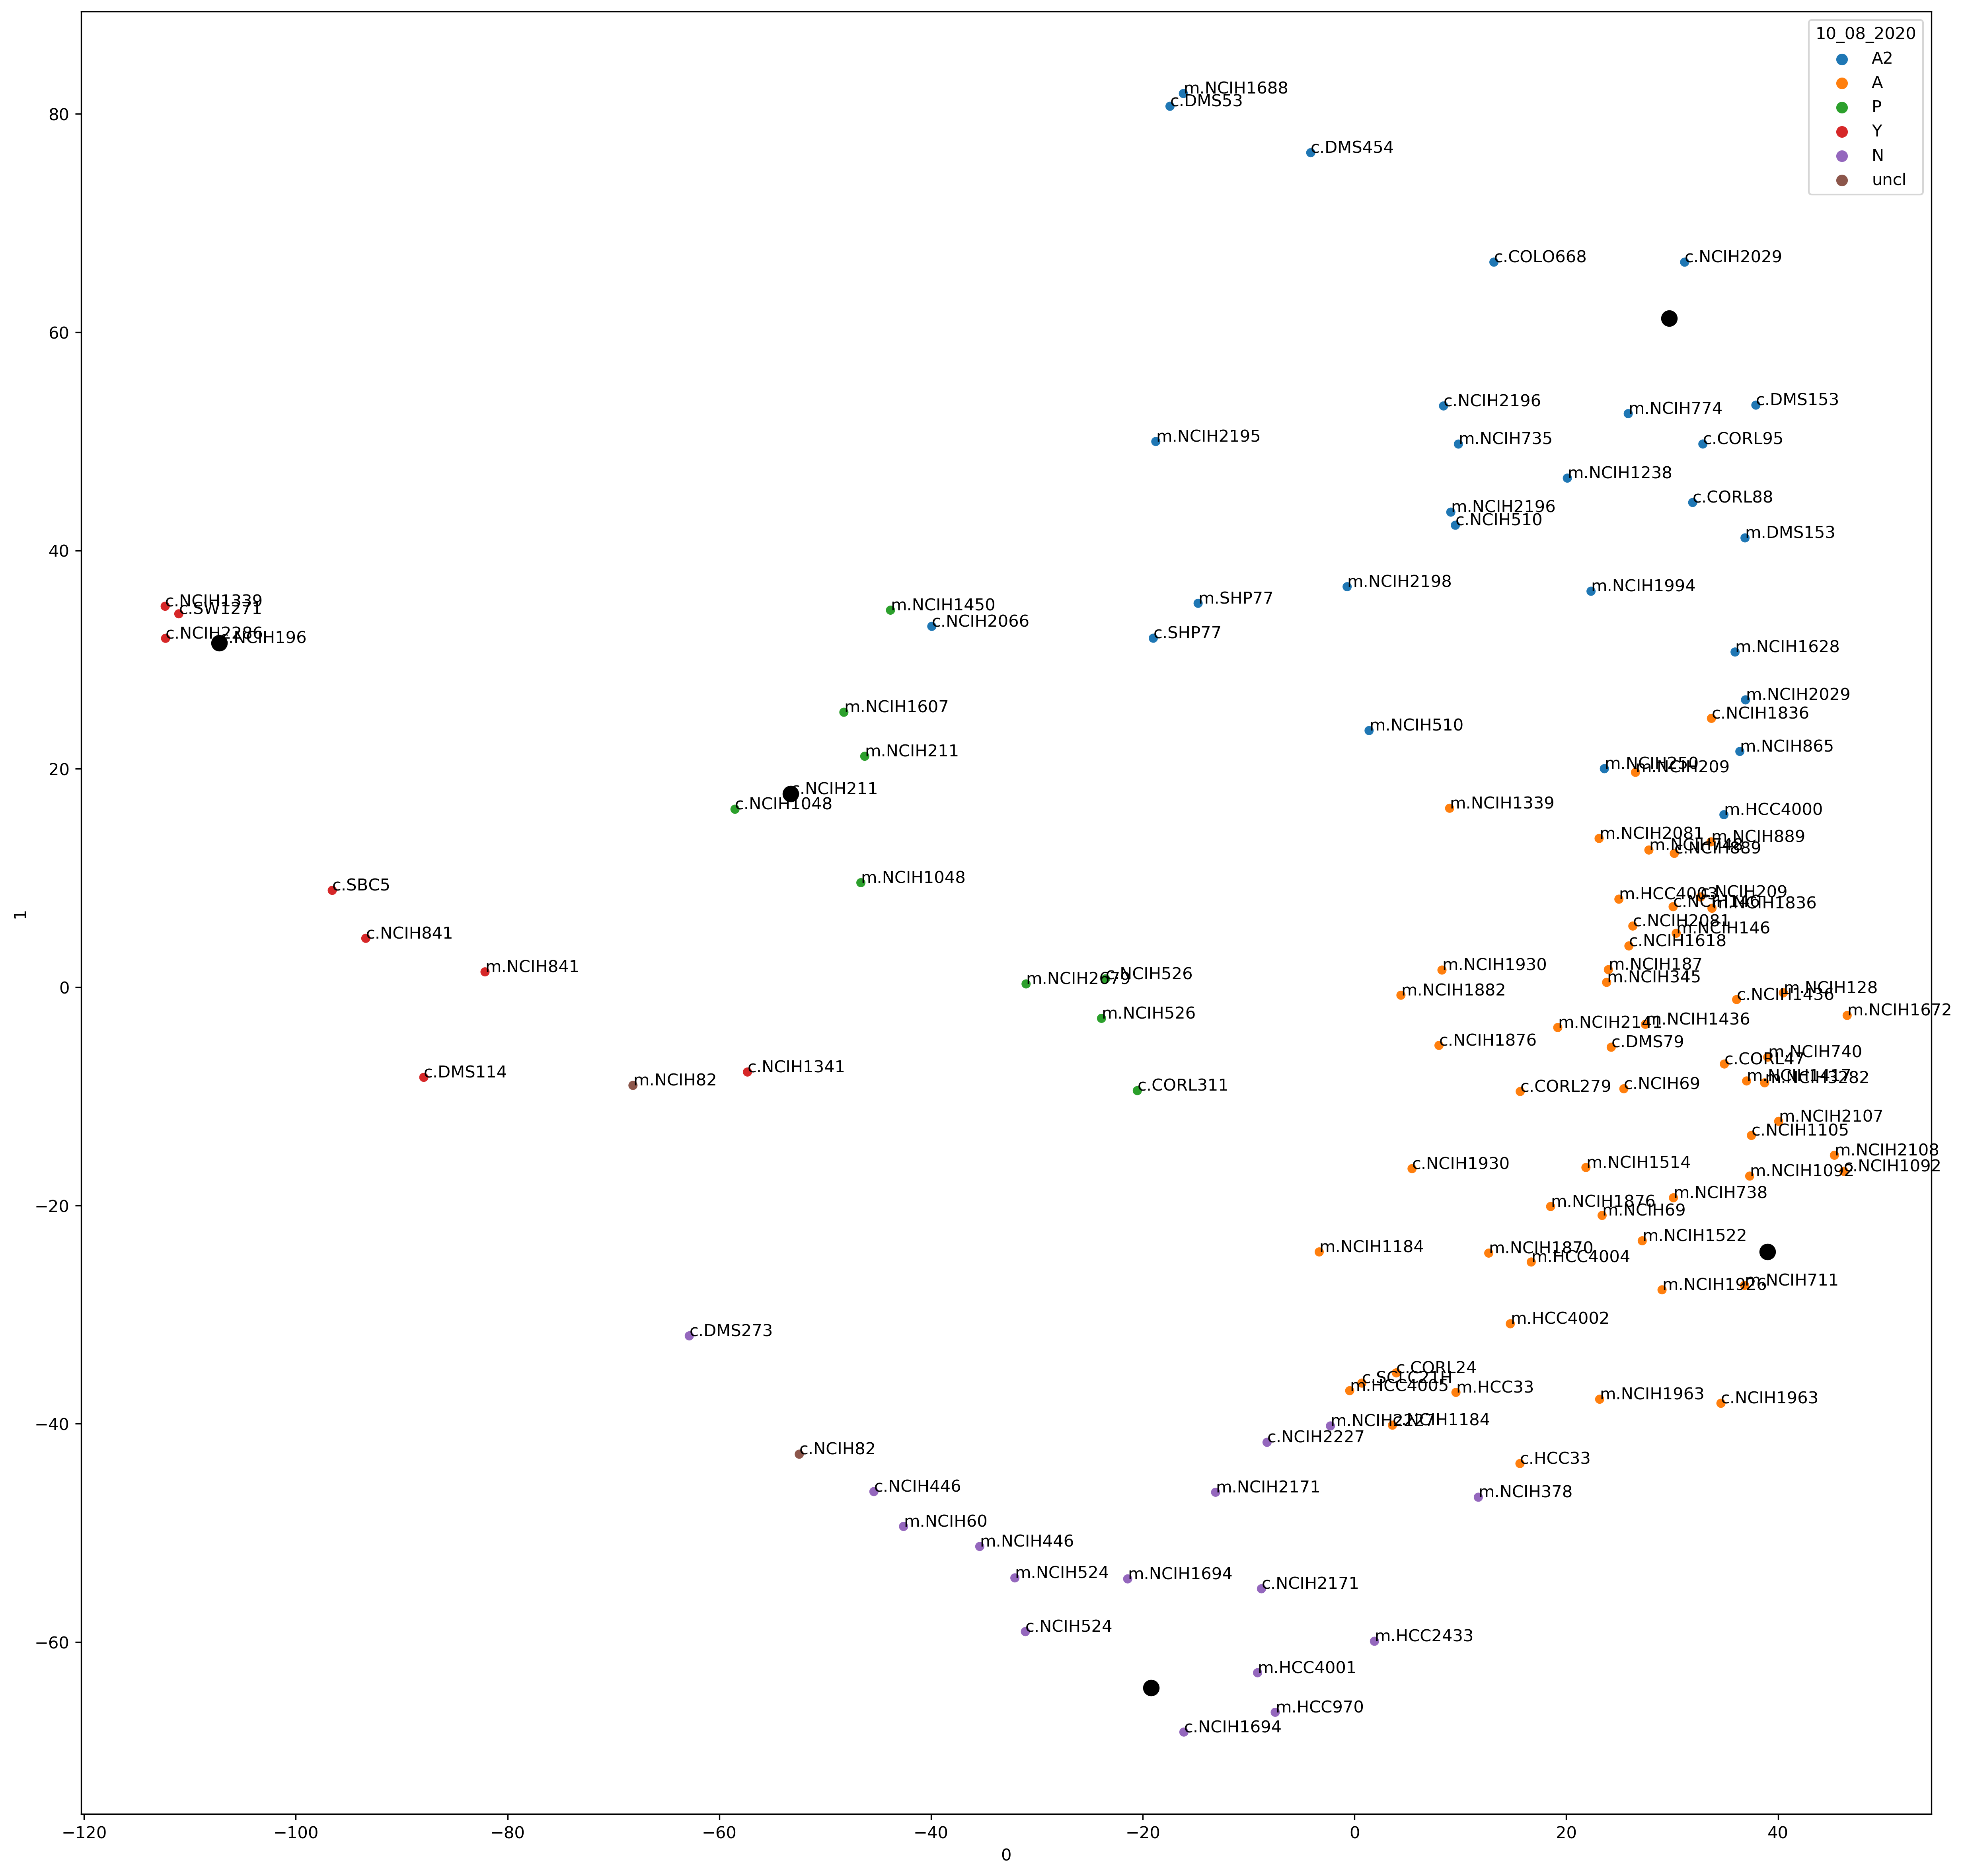

In [155]:
plt.figure(figsize = (20,20), dpi = 300)
sns.scatterplot(pcs[0],pcs[1], hue = clines['10_08_2020'])
plt.scatter(arc_pc.iloc[0],arc_pc.iloc[1], color = 'black', s = 80)
for (x,y, label) in zip(pcs[0],pcs[1],clines.index):
#     if label == "c.NCIH2081":
    plt.text(x,y,label)


... and corresponding scRNA-seq data transformed with the same PCA (after mean-centering the data):

In [55]:
from sklearn import preprocessing as pp

sc_pc_genes = sorted(list(set(adata.var_names).intersection(pc_loadings.index)))
sc_pc_loadings = pc_loadings.loc[sc_pc_genes]
sc_data = data[sc_pc_genes]
adata_df = pd.DataFrame(adata.X.todense(), index=adata.obs_names, columns=adata.var_names)
adata_df = adata_df[sc_pc_genes]
adata_df = adata_df.T
adata_df_scale = pd.DataFrame(pp.scale(adata_df.T), columns = sc_pc_genes).T
adata_arc = sc_pc_loadings.T.dot(adata_df_scale)

In [95]:
# from py_pcha import PCHA
# XC, S, C, SSE, varexpl = PCHA(np.array(adata_df_scale), noc=5, delta=1)
# XC_pca = sc_pc_loadings.T.dot(XC)

In [148]:
adata_df.to_csv('single_cell_sclc.csv')

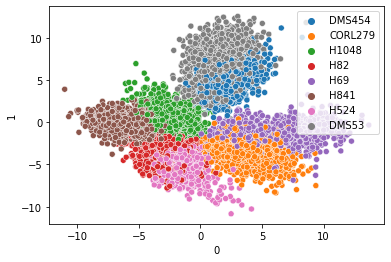

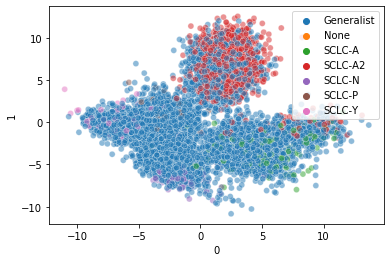

In [158]:
pcs_to_plot = [0,1]

sns.scatterplot(adata_arc.loc[pcs_to_plot[0]],adata_arc.loc[pcs_to_plot[1]], hue = adata.obs['cline'].values)
plt.show()
sns.scatterplot(adata_arc.loc[pcs_to_plot[0]],adata_arc.loc[pcs_to_plot[1]], hue = adata.obs['Phenotype'].values, alpha=.5)
plt.show()

We can see above that the single cell data from the cell lines approximately line up with the bulk RNA-seq data, with Y on the left, P in the middle, A2 at the top, N at the bottom, and A on the right.

Lastly, we'll plot tumor data on the archetype space:

In [525]:
tumors = pd.read_csv('lung_tpm_final.csv', index_col=0, header = 0)
tumors.head()

S00022    S00035    S00050    S00213    S00356    S00472    S00501  \
Gene                                                                           
A1BG    3.971626  2.833514  2.792737  2.961507  2.955939  3.332214  2.889223   
A2M     4.653913  4.763524  5.248839  5.631358  6.150907  5.361458  5.857942   
A2ML1   0.000000  0.000000  0.000000  0.000000  0.000000  0.030815  0.000000   
A4GALT  3.186498  3.394310  2.871253  2.846558  2.216998  3.322920  3.929338   
AAAS    3.908311  3.309278  3.451605  3.151845  3.976601  3.999645  3.620763   

          S00825    S00827    S00829  ...    S02351    S02352    S02353  \
Gene                                  ...                                 
A1BG    3.075778  2.814519  2.267827  ...  3.206683  3.276152  4.133326   
A2M     6.834538  5.650582  5.471909  ...  4.944198  5.936320  5.708024   
A2ML1   0.000000  0.000000  0.000000  ...  0.000000  0.078949  0.000000   
A4GALT  2.689807  2.914458  2.057248  ...  3.434869  3.397004  3.769095   
AAAS    3.354868  3.930432  3.609098  ...  3.972863  3.795622  4.316948   

          S02354    S02360    S02375    S02376    S02378    S02382    S02397  
Gene                                                                          
A1BG    3.503443  3.136499  1.780874  1.561214  2.481569  2.205254  2.176689  
A2M     5.664792  4.711961  5.030952  4.757905  6.426368  5.815585  5.749103  
A2ML1   0.000000  0.000000  0.000000  0.000000  0.037669  0.000000  0.000000  
A4GALT  3.113416  2.863493  3.283889  2.422831  3.732642  3.563277  2.240693  
AAAS    4.141142  4.061237  4.007279  3.398061  3.489976  4.100482  3.743781  

[5 rows x 81 columns]

In [607]:
tumor_pc_genes = sorted(list(set(tumors.index).intersection(pc_loadings.index).intersection(set(adata.var_names))))
tumor_pc_loadings = pc_loadings.loc[tumor_pc_genes]
tumor_data = data[tumor_pc_genes]
tumors = tumors.loc[tumor_pc_genes]
tumors_scale = pd.DataFrame(pp.scale(tumors.T), columns = tumor_pc_genes).T
tumors_arc = tumor_pc_loadings.T.dot(tumors_scale)

In [591]:
XC, S, C, SSE, varexpl = PCHA(np.array(tumors_scale), noc=3, delta=1)
XC_pca = tumor_pc_loadings.T.dot(XC)

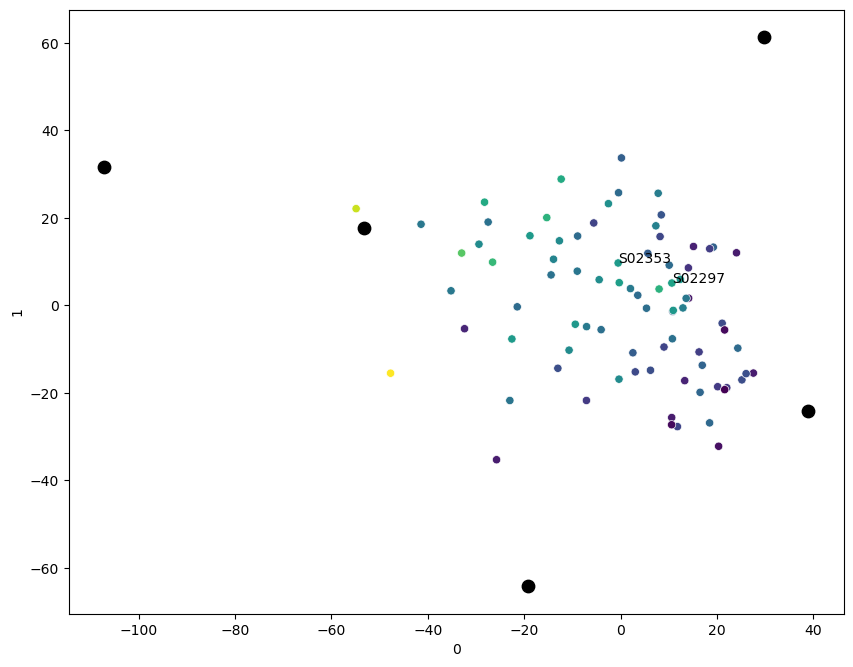

In [705]:
pcs_to_plot = [0,1]
plt.figure(figsize = (10,8), dpi = 100)
# sns.scatterplot(pcs[pcs_to_plot[0]],pcs[pcs_to_plot[1]], hue = clines['10_08_2020'])
plt.scatter(arc_pc.iloc[pcs_to_plot[0]],arc_pc.iloc[pcs_to_plot[1]], color = 'black', s = 80)
# plt.scatter(np.array(XC_pca)[pcs_to_plot[0]],np.array(XC_pca)[pcs_to_plot[1]], color = 'red', s = 80)

sns.scatterplot(tumors_arc.loc[pcs_to_plot[0]],tumors_arc.loc[pcs_to_plot[1]], c = tumors.loc['YAP1'])
for (x,y, label) in zip(tumors_arc.loc[pcs_to_plot[0]],tumors_arc.loc[pcs_to_plot[1]],tumors.columns):
    if label in ['S02353','S02297']: #these two samples = chromothrypsis
        plt.text(x,y,label)



In [856]:
# n_sample = len(pcs.columns)
# total_var = (np.array(data.T)**2).sum(axis = None)/(n_sample-1)
# k = 50
# np.array([(np.array(pcs)[:, i]**2).sum()/(n_sample-1) for i in range(k)]).round(2)


In [857]:
# k = 81
# dx = 1
# X  = np.arange(0, k, dx)
# Y  = np.array([(np.array(tumors_arc)[:, i]**2).sum()/(n_sample-1) for i in range(k)]).round(2)


# # Normalize the data to a proper PDF
# Y /= (dx * Y).sum()

# # Compute the CDF
# CY = np.cumsum(Y * dx)

# # Plot both
# plt.plot(X, Y)
# plt.plot(X, CY, 'r--')


## Cell lines that have already been analyzed by CyTOF
- H69: A-N
- Corl279: A-N
- H524: N
- DMS 53: A2
- H889: A-A2
- DMS153: A2
- DMS454: A2
- H2195: A-A2-Y
- H82: generalist
- H446: generalist
- H1607: P-Y
- H196: Y
- H211: P
- H1048: P-Y
- H841: Y

## Cell lines that are "in between" archetypes based on 4-TF expression

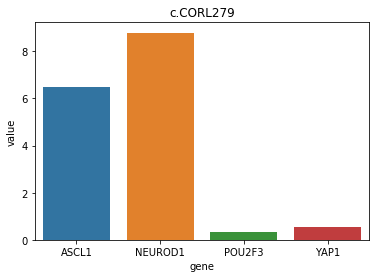

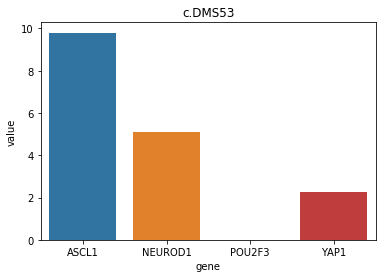

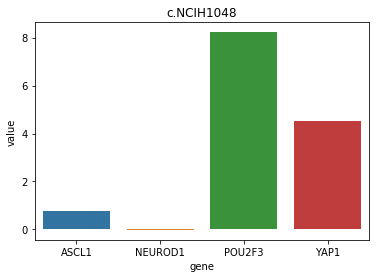

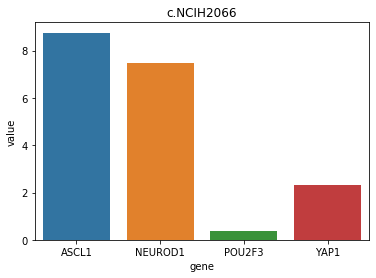

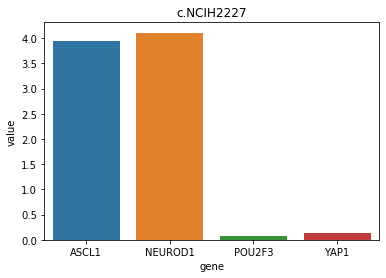

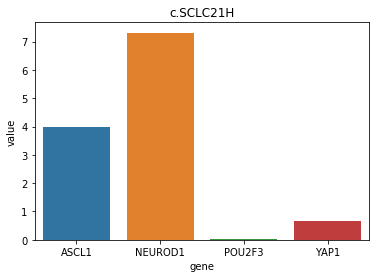

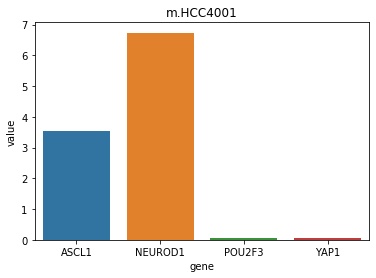

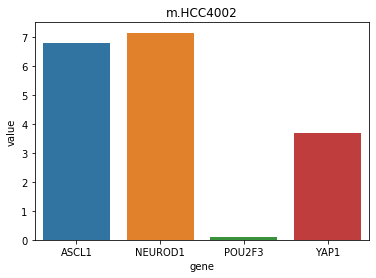

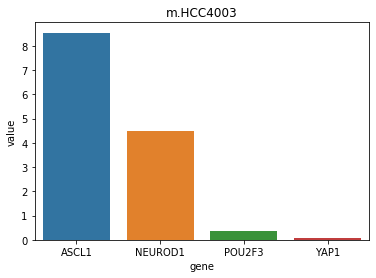

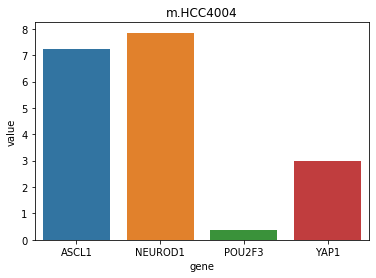

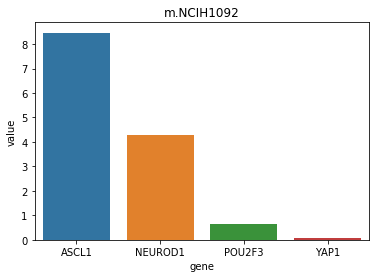

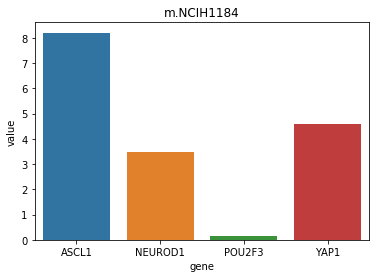

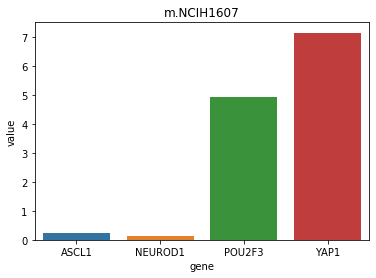

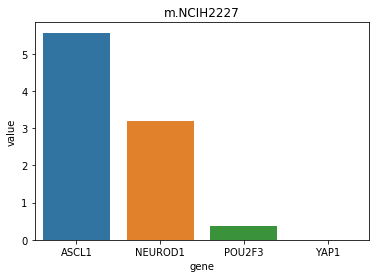

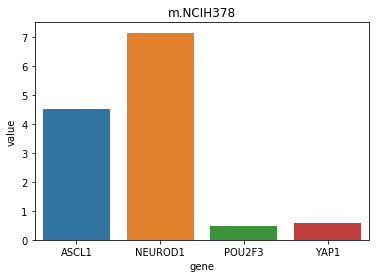

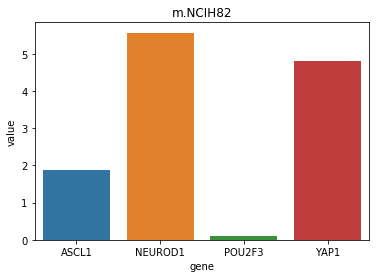

In [40]:
distances.loc[distances.min(axis = 1)>140].index
df = data.copy()
df['cline'] = df.index
genes = ['ASCL1','NEUROD1','POU2F3','YAP1']
df = pd.melt(df, id_vars = 'cline', value_vars=genes, var_name='gene')
mixed = []
for (x,y, label) in zip(pcs[pcs_to_plot[0]],pcs[pcs_to_plot[1]],clines.index):
    try:
        df_sub = df.loc[df['cline'] == label]
        if df_sub['value'].max() > 3 and df_sub.sort_values('value', ascending=False).reset_index().loc[1]['value'] > .5* df_sub['value'].max(): 
            #highest value is greater than 5 and second highest value is at least 80% of top
#         if label in distances.loc[distances.min(axis = 1)>130].index:
            df_sub = df.loc[df['cline'] == label]
            mixed.append(label)
            sns.barplot(data = df_sub, x = 'gene', y = 'value')
            plt.title(label)
            plt.show()
#         elif label.split('.NCI')[1] in adata.obs['cline'].cat.categories:
#             df_sub = df.loc[df['cline'] == label]
#             sns.barplot(data = df_sub, x = 'gene', y = 'value')
#             plt.title(label)
#             plt.show()
    except IndexError: pass

and showing where these are in the PCA:

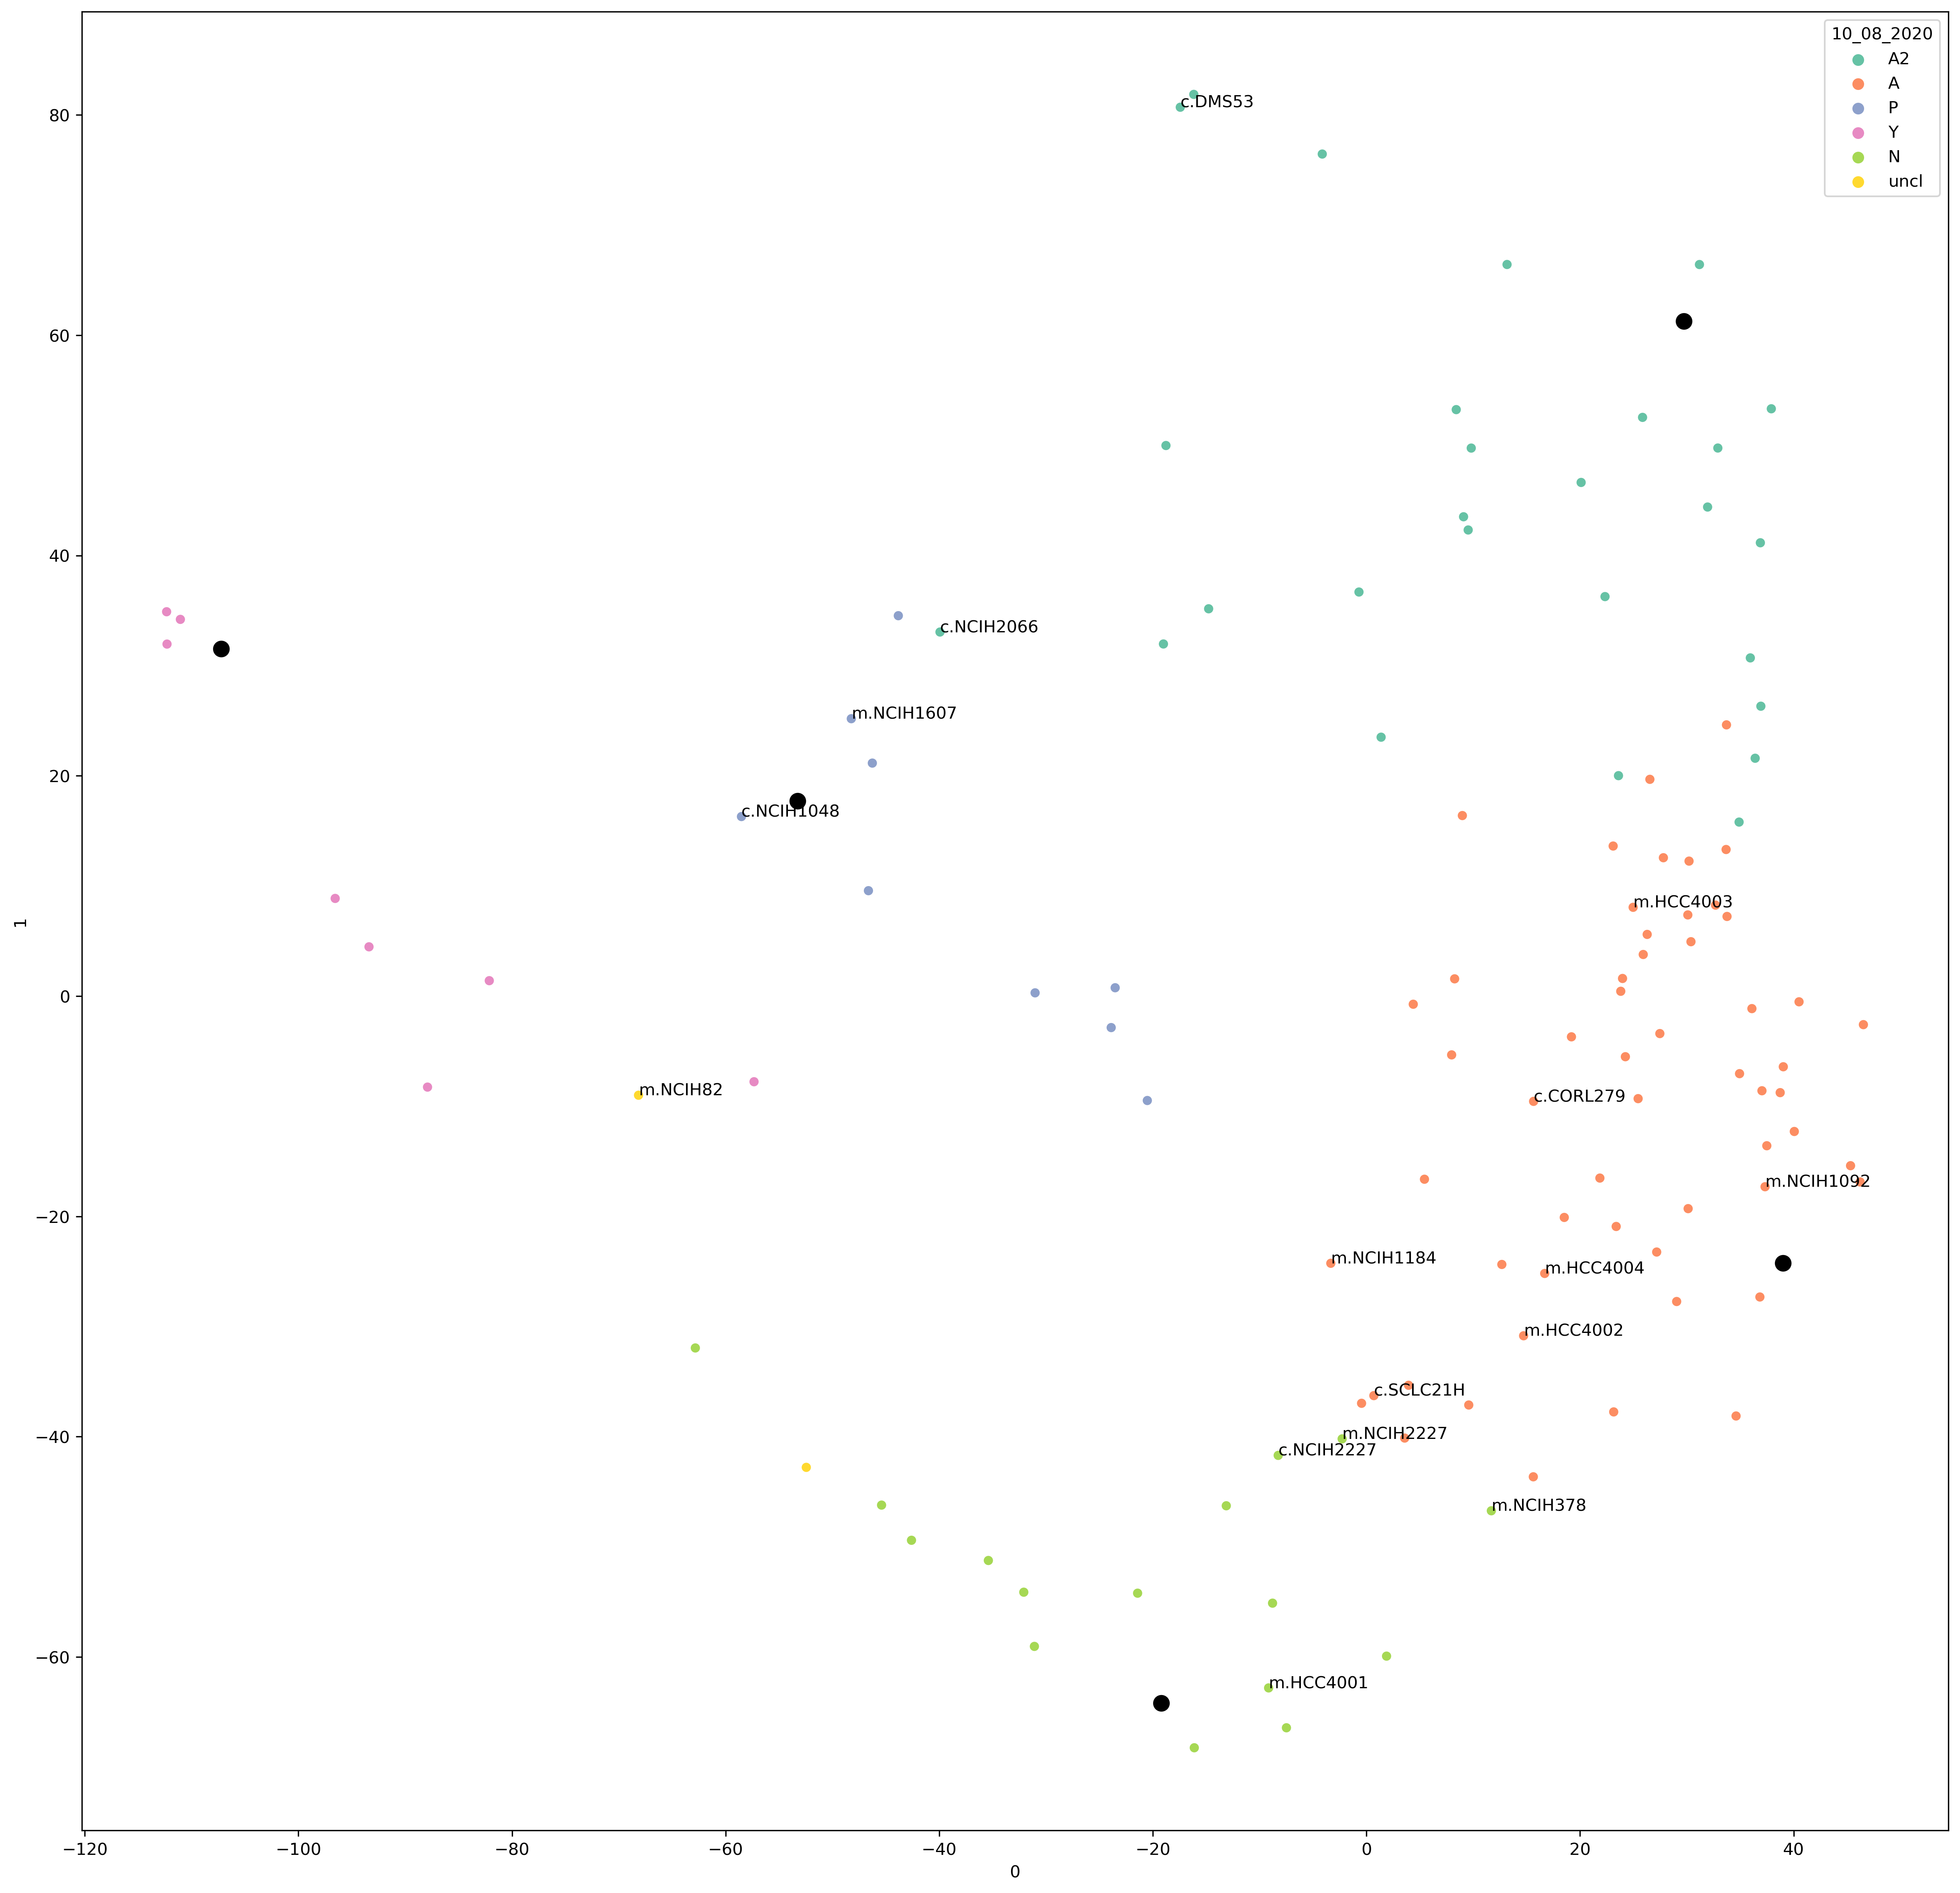

In [57]:
plt.figure(figsize = (20,20), dpi = 300)
sns.scatterplot(pcs[0],pcs[1], hue = clines['10_08_2020'], palette = 'Set2')
plt.scatter(arc_pc.iloc[0],arc_pc.iloc[1], color = 'black', s = 80)
for (x,y, label) in zip(pcs[0],pcs[1],clines.index):
    if label in mixed: 
        plt.text(x,y,label)

# Generalists are adaptable and poised to diversify and regenerate the specialist populations


## Background and Goal
Generalists should be adaptable, and able to regenerate multiple different cell types depending on where they fall in the continuum. We therefore will test whether sorting out specialists and generalists give populations that are able to regenerate the continuum. 
 
We already know that some cell lines are mixed, and each population can regnerate the other (such as H446). These might be a good test case for flow sorting.

The goal of these experiments is to sort generalist populations from specialists via cell surface markers corresponding to archetypes, and test the adaptability of generalists.
- A: **H2108, H1926**
- N: **HCC4001, H524, H60**
- A2: **DMS153, H1238**
- P: **H211, H526, H1048**
- Y: **H2286 or SW1271**
- Intermediate:
  - A-N cell lines: **CORL279,CORL24,H378, H69** (almost equidistant from A, A2, and N, but closest to A)
  - A2-P: **H2066**
  - P-Y cell line: **H1048, DMS114**
  - N-P(-A?): **CORL311**
  - N-Y: **H446** (mixed population-- will be interesting to see if it is N+Y or N-Y intermediate)
  - Generalist enriched cell line: **H82**
  - Far from every archetype: **H1341**

## Cell surface markers

In [58]:
markers = pd.read_csv('surface_markers.txt', header = 0)

An example surface marker that we know is associated with SCLC-A2 is shown below. CEACAM5 expression is (anti-)correlated with distance from the SCLC-A2 archetype.

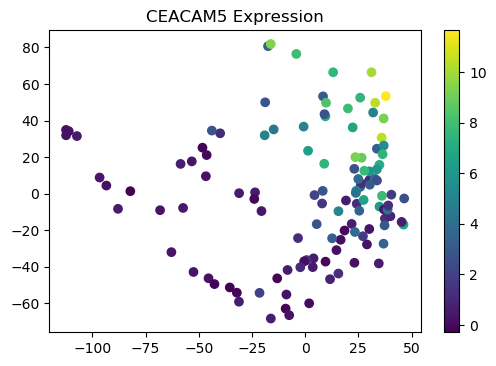

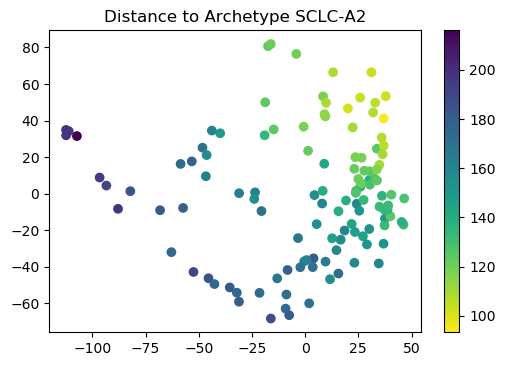

In [59]:
plt.figure(dpi = 100)
plt.scatter(pcs[0],pcs[1], c = data['CEACAM5'], cmap='viridis', )
plt.title('CEACAM5 Expression')
plt.colorbar()
plt.show()
plt.figure(dpi = 100)
plt.scatter(pcs[0],pcs[1], c = distances['SCLC-A2'], cmap='viridis_r')
plt.title("Distance to Archetype SCLC-A2")
plt.colorbar()
plt.show()

To determine which other surface markers correlate with archetypes, we test if expression of the marker across cell lines is inversely correlated to distance from each archetype. An arbitrary cut-off of 0.65 was set, which gave a relatively short list with markers for every archetype except P.

In [60]:
from scipy.stats import pearsonr, spearmanr
surface_markers = []
marker_subtype = []
for subtype in sorted(distances):
    for m in markers['gene_symbol']:
        try:
            corr, _ = spearmanr(distances[subtype], data[m])
            if -corr > .65:
                surface_markers.append(m)
                marker_subtype.append(subtype)

        except KeyError: pass



There are no good surface markers for P, but these have a correlation > .3:
- BMPR1B SCLC-P
- CGN SCLC-P
- CR2 SCLC-P
- DSG2 SCLC-P
- ERBB3 SCLC-P
- HHIP SCLC-P
- HNRNPK SCLC-P
- IL17D SCLC-P
- LAMA2 SCLC-P
- MME SCLC-P
- PROM2 SCLC-P
- SLC7A5 SCLC-P
- TMEM87A SCLC-P
- TNFRSF10A SCLC-P
- TNFRSF18 SCLC-P
- VEGFC SCLC-P

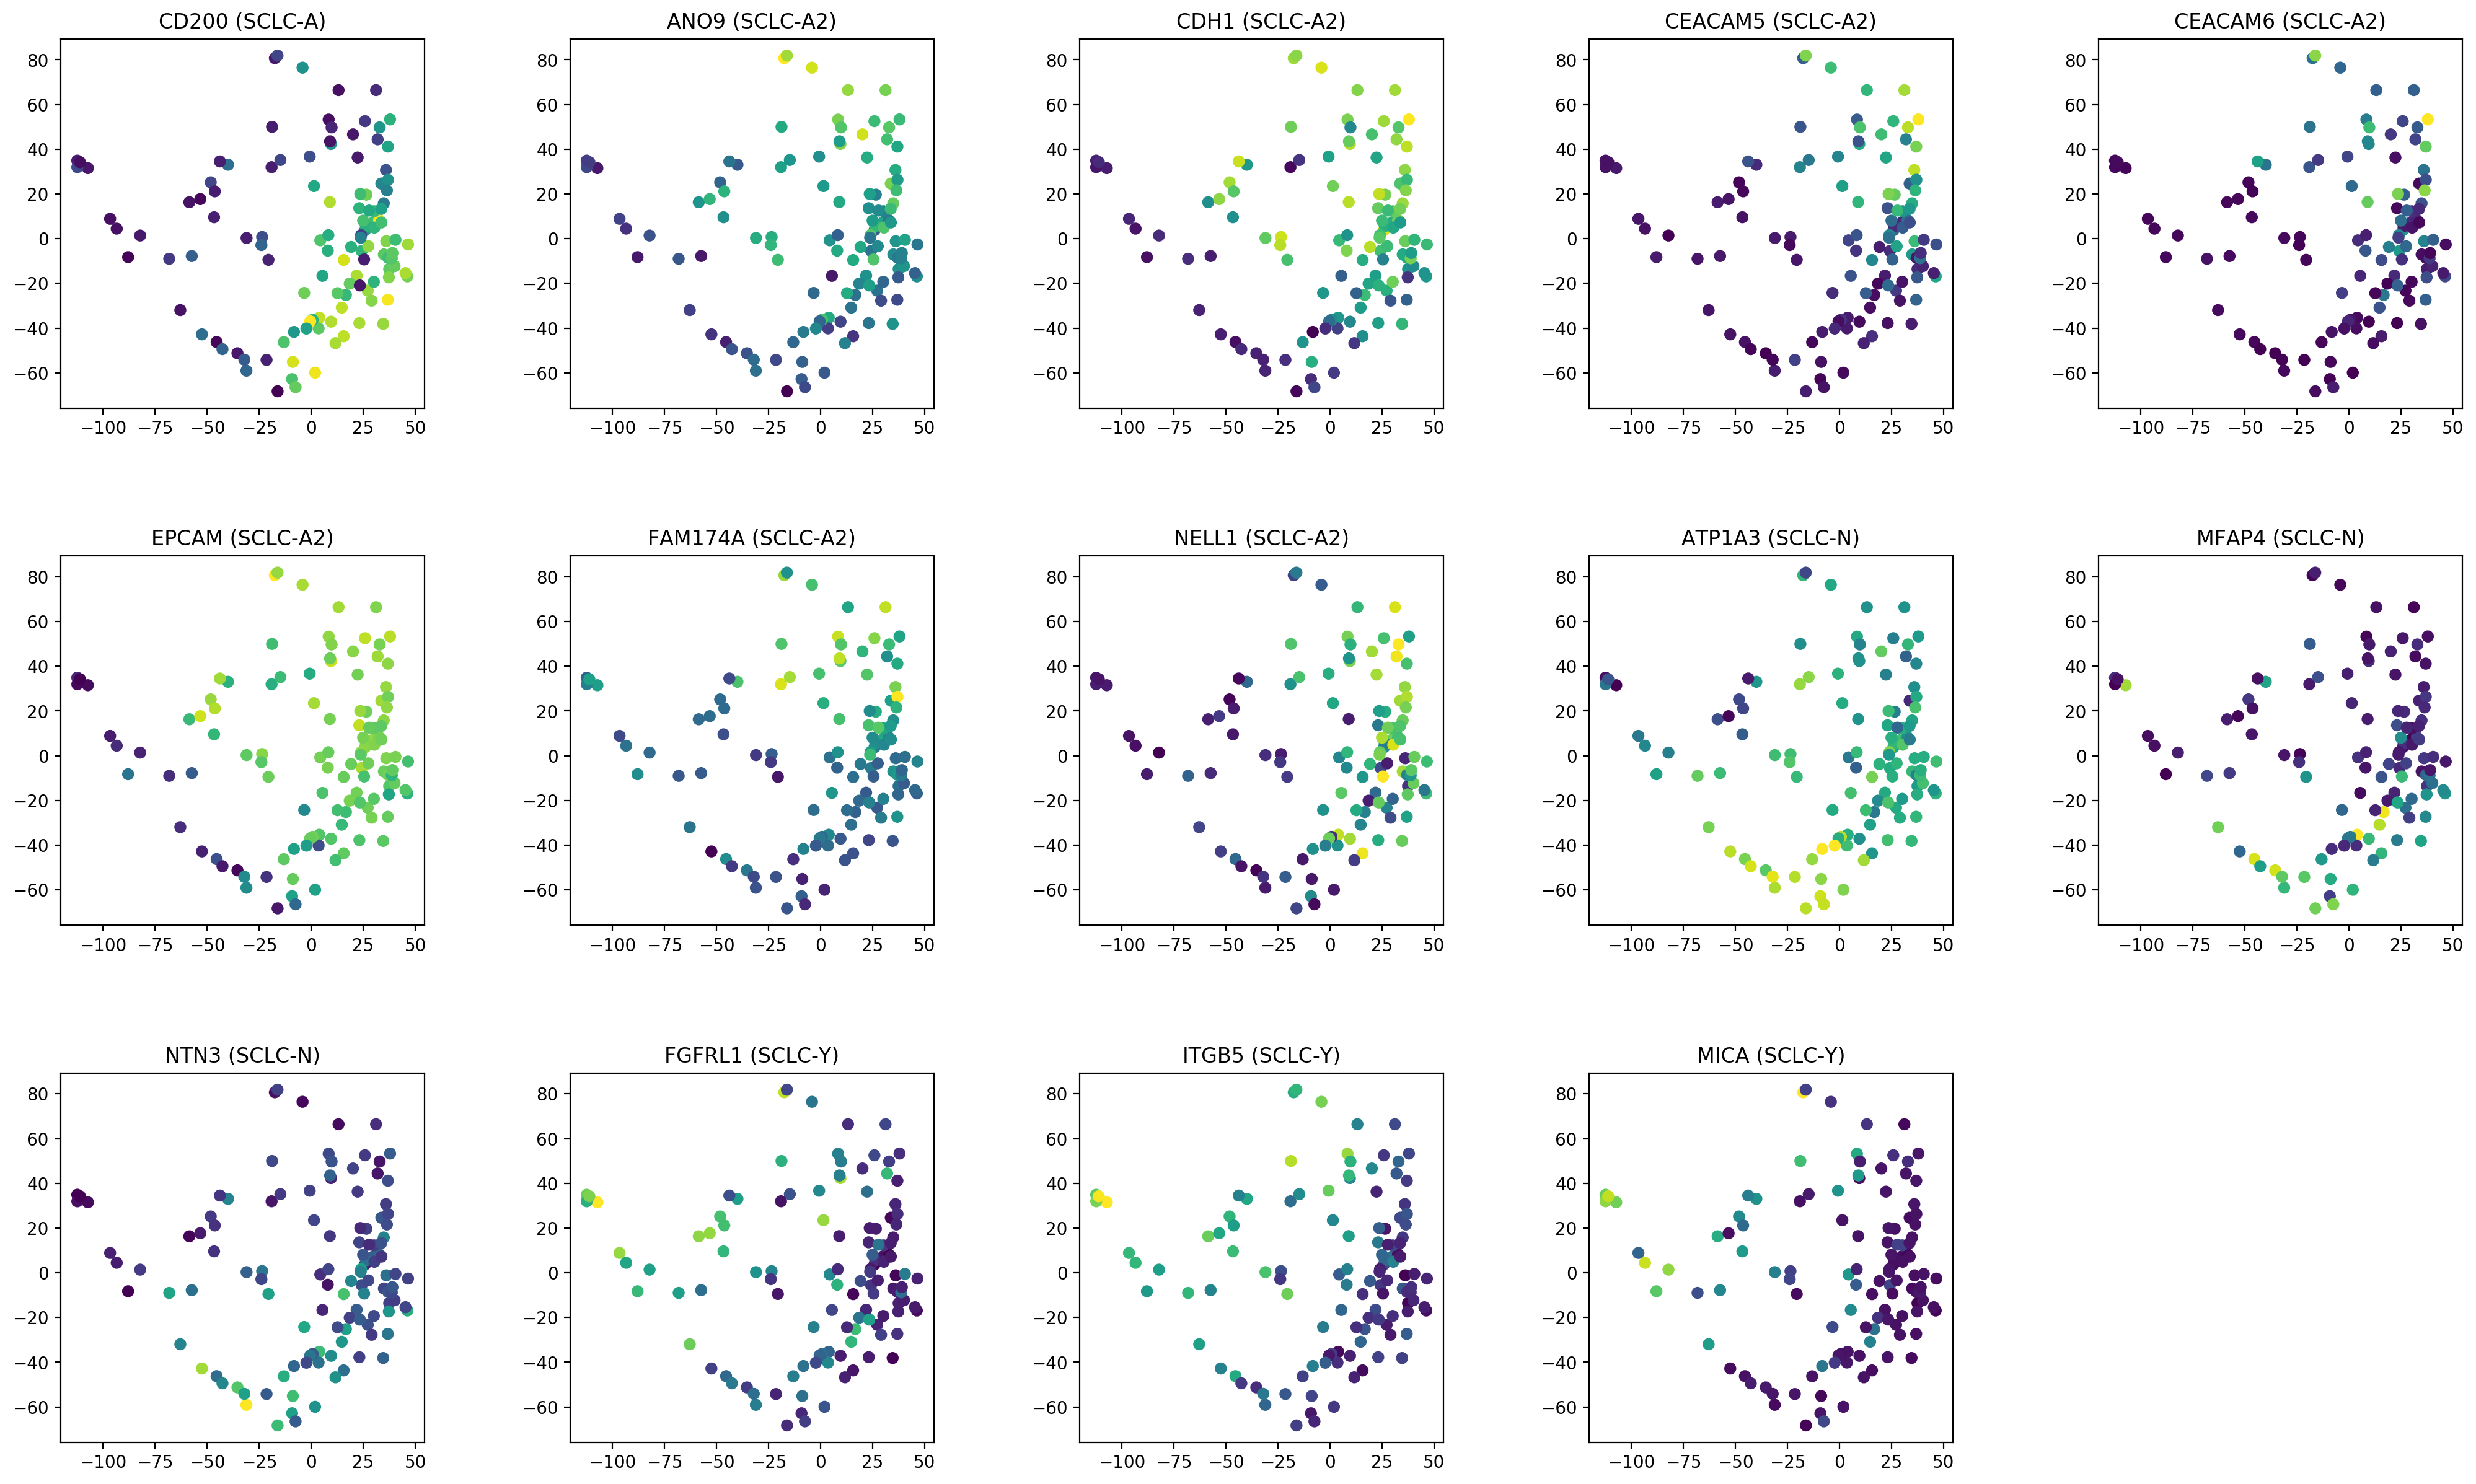

In [61]:
fig = plt.figure(figsize = (25,15), dpi = 200)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i,m in enumerate(surface_markers):
    ax = fig.add_subplot(3, 5, i+1)
    ax.scatter(pcs[0],pcs[1], c = data[m], cmap='viridis')
    plt.title(m + " (" +marker_subtype[i] +")")


## Final list of cell surface markers that correlate with archetypes:

- A: CD200 (only one that seems specific to A, not ASCL1+)
- A2: CEACAM5 or FAM174A seem best
- N: ATP1A3, MFAP4, or NTN3
- Y: FGFRL1, ITGB5, or MICA

Unfortunately there were no surface markers that correlated with the P archetype, even though there are genes that are enriched in that subtype. For example, POU2F3 is enriched in P cells exclusively, but is not correlated very highly with distance to archetype, most likely because there are very few SCLC-P cell lines and after some distance away from the P archetype, all cell lines have no expression, flattening the correlation between POU2F3 and distance.

Spearman correlation: 0.1937495659420793


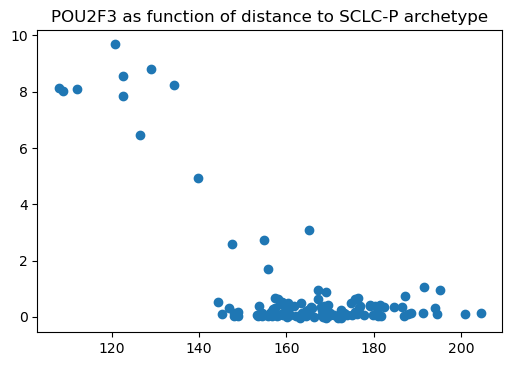

In [62]:
print("Spearman correlation: " + str(-spearmanr(distances['SCLC-P'], data['POU2F3'])[0]))
plt.figure(dpi = 100)
plt.scatter(distances['SCLC-P'], data['POU2F3'])
plt.title("POU2F3 as function of distance to SCLC-P archetype")
plt.show()

The pearson correlation is much stronger for POU2F3, but no surface markers have a high Pearson correlation.

In [63]:
print("Pearson correlation: " + str(-pearsonr(distances['SCLC-P'], data['POU2F3'])[0]))


Pearson correlation: 0.7126910010645461


We can look at which markers we'd expect to work well, based on the single cell RNA-seq data. However, it is important to note that some of these markers are dropped out, and it is not always clear what a true "positive" or "negative" phenotype should be.

We use MAGIC to impute data for the markers above, because most single cell data is zero.

In [64]:
import magic
fast_magic_operator = magic.MAGIC(
    t="auto", solver="approximate", decay=None, knn=10, verbose=True)
magic_op = magic.MAGIC(solver="approximate") 
adata_magic= magic_op.fit_transform(adata, genes="all_genes")


Calculating MAGIC...
  Running MAGIC on 16671 cells and 18265 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 6.65 seconds.
    Calculating KNN search...
    Calculated KNN search in 38.95 seconds.
    Calculating affinities...
    Calculated affinities in 37.16 seconds.
  Calculated graph and diffusion operator in 82.79 seconds.
  Calculating imputation...
  Calculated imputation in 0.12 seconds.
Calculated MAGIC in 85.15 seconds.


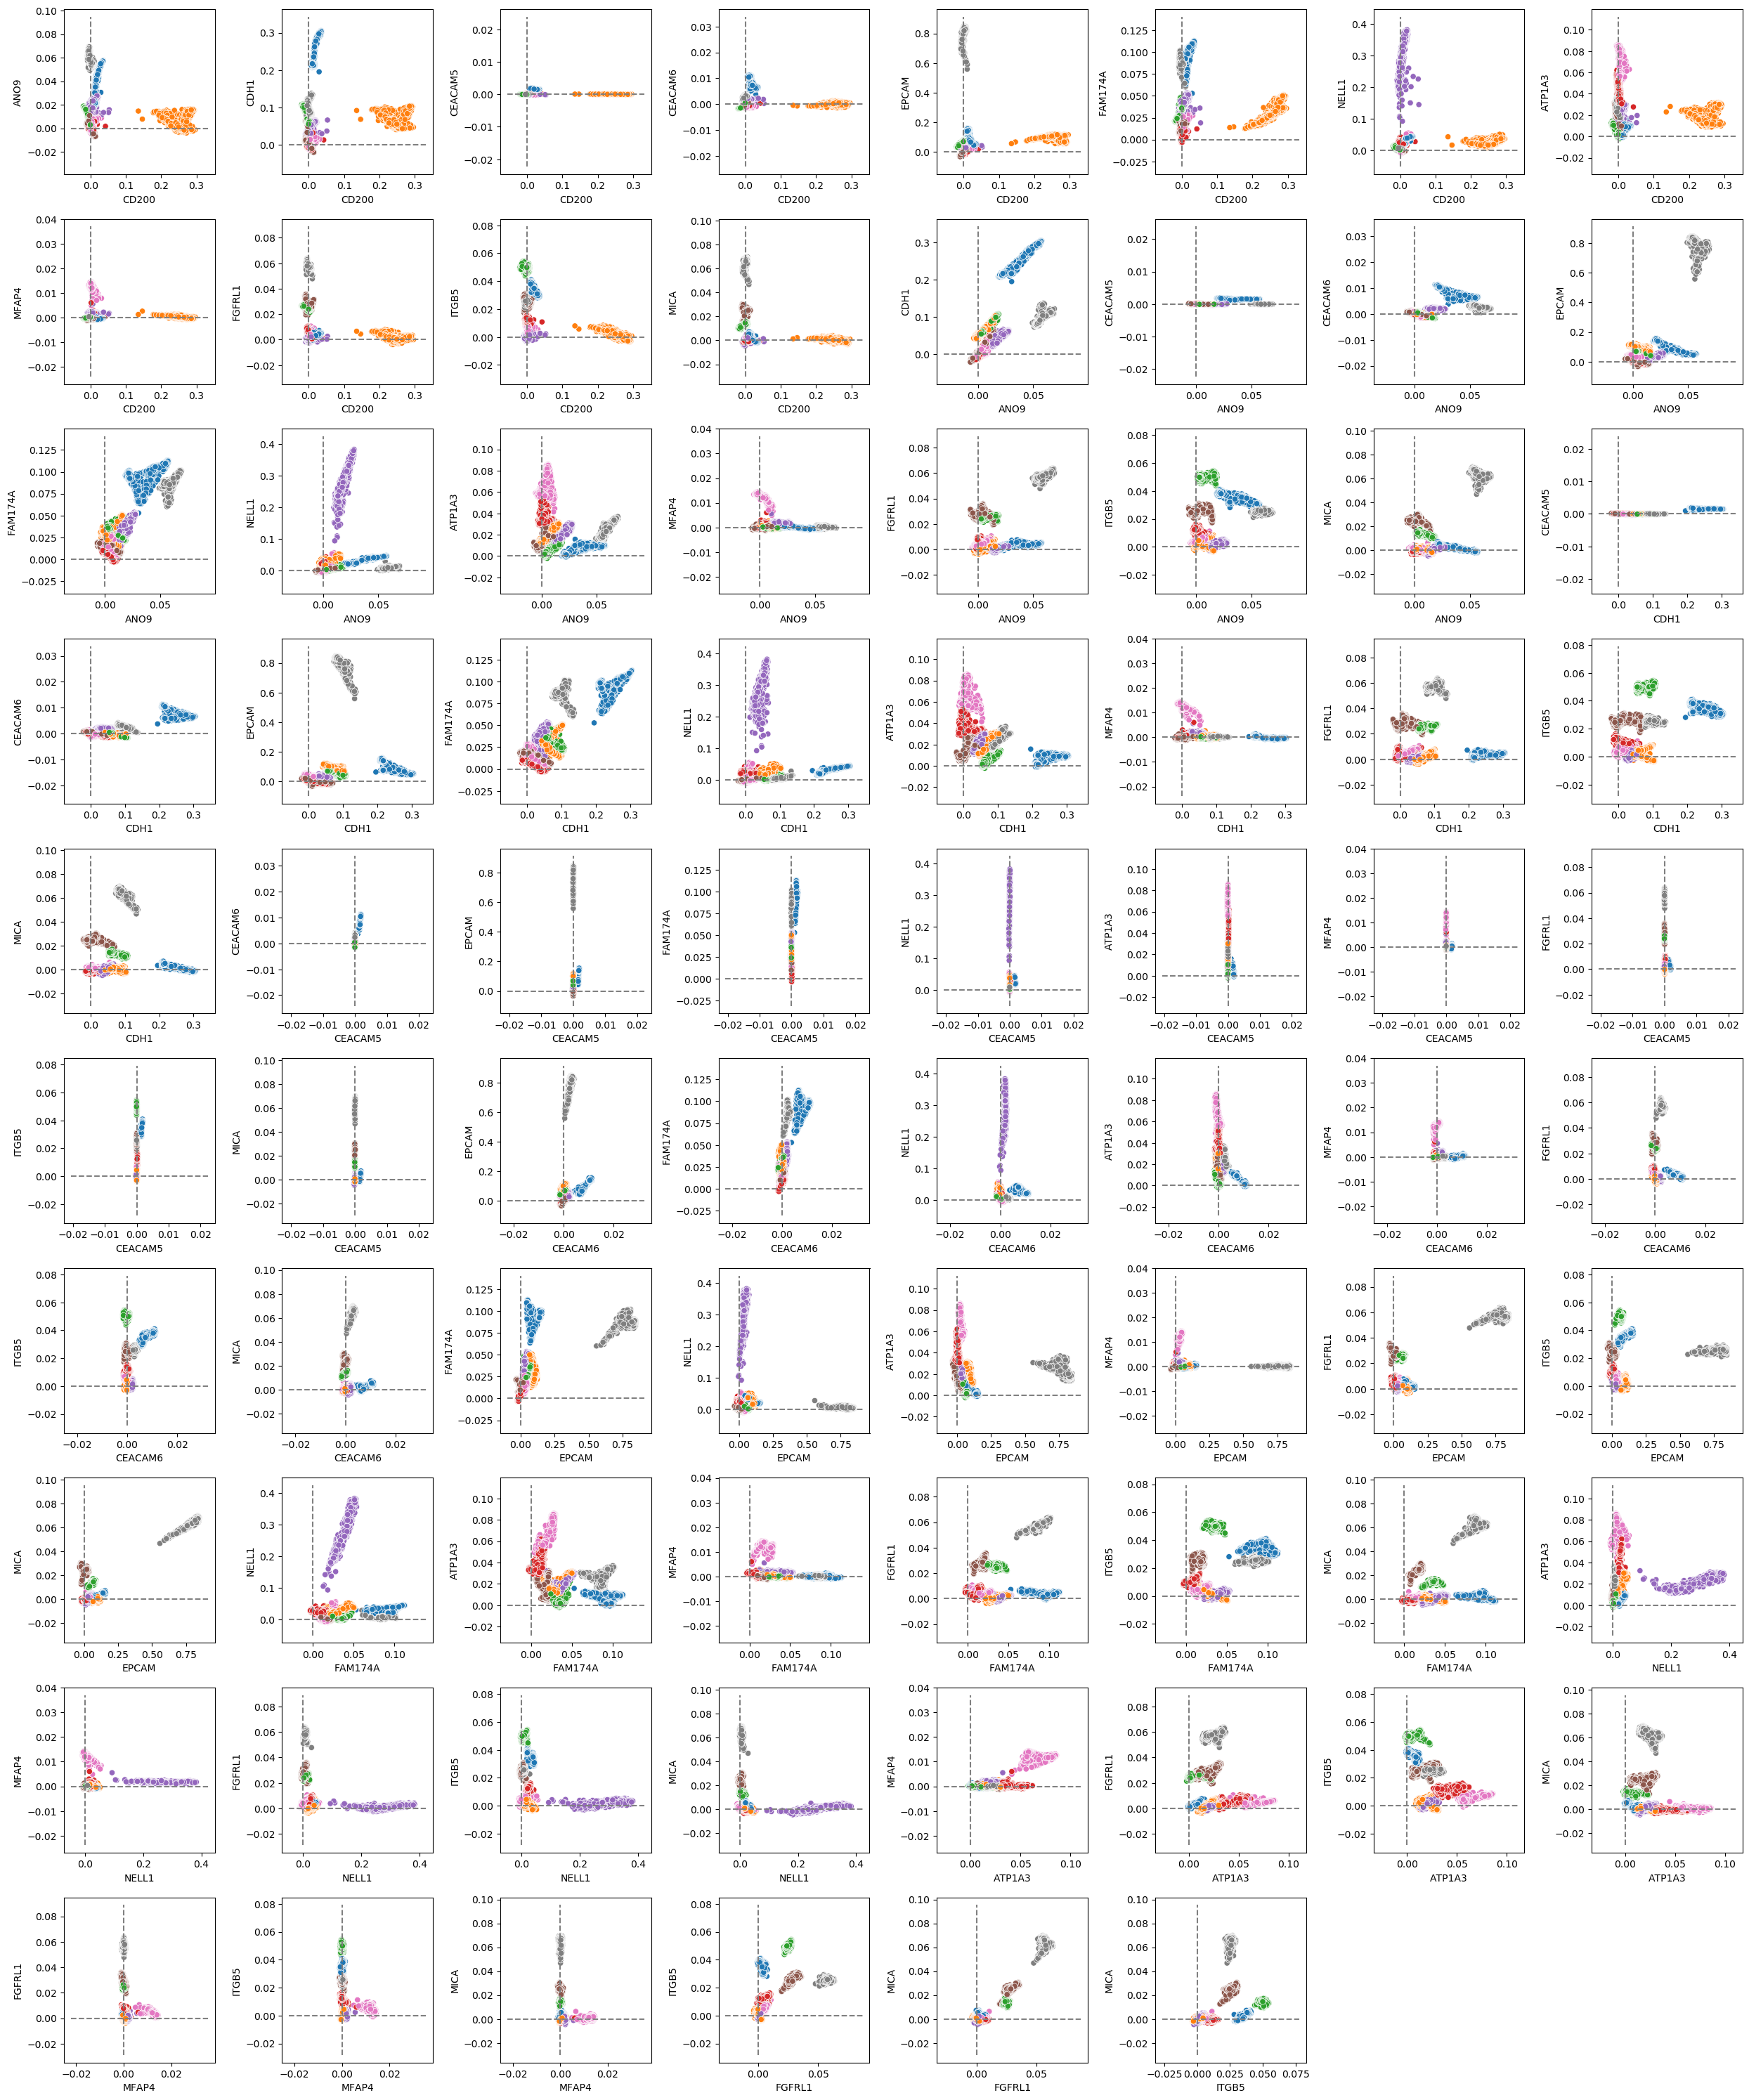

In [671]:
import itertools as it
fig = plt.figure(figsize = (25,30), dpi = 100)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
surface_markers_sc = [i for i in surface_markers if i in adata_magic.var_names]
for x,(i,j) in enumerate(it.combinations(surface_markers_sc, r = 2)):
    if adata_magic.obs_vector(i).max() == 0 or adata_magic.obs_vector(j).max() == 0: pass
    try:
        ax = fig.add_subplot(10, 8, x+1)
        sns.scatterplot(adata_magic.obs_vector(i), adata_magic.obs_vector(j), hue = adata.obs["cline"], ax = ax, legend = False)
        plt.hlines(0, xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], linestyle = '--', color = 'grey')
        plt.vlines(0, ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1], linestyle = '--', color = 'grey')
        plt.xlabel(i)
        plt.ylabel(j)
    except KeyError: pass
plt.tight_layout()



<div class="alert alert-block alert-info">
<b>Conclusions:</b>
    We will need to select specific markers that are upregulated in the expected phenotypes. This will be listed down below. We also will pick some cell lines that are intermediate between two phenotypes. Unfortunately, we did not find a good marker for the P archetype, but we can look at the literature to find markers that should work: TRPM5, COX-1, SIGLECF, or UEA-1</div>
    
https://www.jimmunol.org/content/202/5/1321/tab-figures-data

## Experimental Design


### Materials
1. Cell Lines:
    - CORL279 (A-N)
    - H2066 (A2-P)
    - H1048 (P-Y)
    - CORL311 (N-P)
    - H446 (mixed population-- will be interesting to see if it is N+Y or N-Y intermediate)
    - H82 (all generalists between N-Y)
    - Far from every archetype: H1341
2. Antibodies (markers for each archetype):
    - CD200 (A)
    - CEACAM5/ANO9 (A2)
    - ATP1A3(N)
    - TRPM5 (P) (or alternative from list above if you recognize any of those)
    - ITGB5 (Y)
    


### Methods

We want to see how adaptable generalists are. So for these experiments, we will:
1. Sort out generalists and pool non-generalists using cell surface markers.
2. Compare how they diversify over time, without drug. 
3. We would expect the specialists to be relatively stable, and the generalists to slowly regenerate the specialists, which can be measured by the cell surface markers above. This requires a cell line that has a clear spectrum of specialists and generalists, easily separable by surface markers.
4. This would be the simplest type of experiment to show that generalists are poised to regenerate multiple types of specialists. 

## Expected Results

<div class="alert alert-block alert-info">
<b></b>Our expected results are as follows: generalists should be able to regenerate multiple types of specialists (i.e. two endpoints of a particular cell line's spectrum), but specialists do not necessarily regenerate other specialists. </div>

In [66]:
h82 = adata_magic[adata_magic.obs['cline'] == 'H82']
h1048 = adata_magic[adata_magic.obs['cline'] == 'H1048']
corl279 = adata_magic[adata_magic.obs['cline'] == 'CORL279']

In [82]:
def plot_two_markers(i,j, title):
    fig = plt.figure()
    ax = fig.add_subplot()
    sns.scatterplot(adata_magic.obs_vector(i), adata_magic.obs_vector(j), hue = adata_magic.obs["cline"],ax = ax)
    plt.hlines(0, xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], linestyle = '--', color = 'grey')
    plt.vlines(0, ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1], linestyle = '--', color = 'grey')
    plt.xlabel(i)
    plt.ylabel(j)
    plt.title(title)
    plt.show()

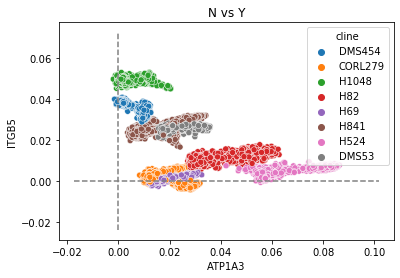

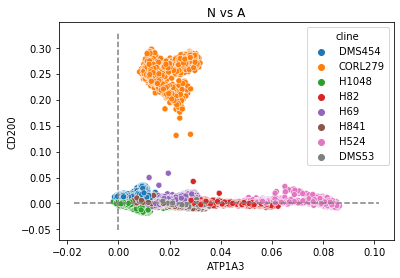

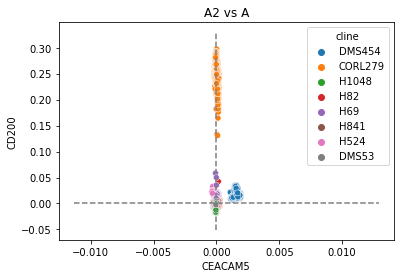

In [91]:
plot_two_markers('ATP1A3','ITGB5','N vs Y')
plot_two_markers('ATP1A3','CD200','N vs A')
plot_two_markers('CEACAM5','CD200','A2 vs A')


# Vertices optimize cancer hallmarks 
Theoretically, we would expect each vertex to be sensitive to drugs that target its hallmark, and generalists should be more resistant/come back faster after treatment/shift phenotype more easily.

## How to move cells with cyotkines



**SCLC-Y** cells optimize the following tasks, suggesting a perturbation using cytokines may be able to shift an environment to favor Y:
- EPITHELIAL MESENCHYMAL TRANSITION
    - EMT-related cytokines (TGF-β1, TGF-β2, TGF-β3, MCP-1, BFGF, TNF-α, IL-1β) 
- INTERFERON ALPHA RESPONSE
    - IFNAs
- TUMOR NECROSIS FACTOR ALPHA SIGNALING VIA NFKB
    - TNFA 
    - https://pubmed.ncbi.nlm.nih.gov/10072259/ Tumor necrosis factor-alpha stimulates attachment of small cell lung carcinoma to endothelial cells
    - https://journals.physiology.org/doi/pdf/10.1152/ajplung.1998.275.2.L311 Tumor necrosis factor induces neuroendocrine differentiation in small cell lung cancer cell lines
- TRANSFORMING GROWTH FACTOR BETA SIGNALING
    - TGFB (induces cell death)
    - https://www.nature.com/articles/celldisc201526 EZH2 promotes progression of small cell lung cancer by suppressing the TGF-β-Smad-ASCL1 pathway
    - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1968423/ Expression of transforming growth factor beta (TGF beta) receptors and expression of TGF beta 1, TGF beta 2 and TGF beta 3 in human small cell lung cancer cell lines.
- INTERLEUKIN 6 JAK STAT3 SIGNALING
    - IL6
    - https://ar.iiarjournals.org/content/30/5/1773
- INTERFERON GAMMA RESPONSE
    - Low-Dose IFNγ Induces Tumor Cell Stemness in Tumor Microenvironment of Non–Small Cell Lung Cancer
- HYPOXIA
    - HIF1A
    -  Acellular components of the microenvironment, such as hypoxia, trigger transcriptional activity through the Hypoxia Inducible Factor 1 (HIF1) signaling pathway and promote activation of stemness-associated transcription factors 
- IL2 STAT5 SIGNALING
    - Decrease of interleukin-2 secretion is a new independent prognostic factor associated with poor survival in patients with small-cell lung cancer
- GLYCOLYSIS
    - cell growth, proliferation, and glucose metabolism are coordinately regulated by interleukin-3 (IL-3) in cytokine-dependent cells. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4458073/
- VEGF
    - https://pubmed.ncbi.nlm.nih.gov/24338338/#readcube-epdf Over-expression of survivin and VEGF in small-cell lung cancer may predict the poorer prognosis

**SCLC-P** tasks:
- REACTIVE OXYGEN SPECIES PATHWAY
    -  https://link.springer.com/article/10.1007/s00044-017-1835-8
    - 2,2′-azobis (2-amidinopropane) dihydrochloride (AAPH) induces ROS and reduces cell death with minimum concentration and short incubation time.
    - you can induce temporary ROS accumulations with low dose of menadione, paraquat, diamide. But in many case this increase will be only temporary, because cells increasing ROS scavenging capacity and try to overcome this dis-balance
    - https://www.thermofisher.com/us/en/home/references/molecular-probes-the-handbook/probes-for-reactive-oxygen-species-including-nitric-oxide/generating-and-detecting-reactive-oxygen-species.html
- CHOLESTEROL HOMEOSTASIS
- MYC TARGETS V1
- MTORC1 SIGNALING
    - The mTOR pathway is particularly sensitive to the levels of nutrients, such as amino acids (Hara et al. 1998) and glucose (Kim et al. 2002), and of ATP (Dennis et al. 2001) https://www.cell.com/molecular-cell/fulltext/S1097-2765(03)00114-X?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS109727650300114X%3Fshowall%3Dtrue
- GLYCOLYSIS
- PEROXISOME
- Dietary succinate and perturbations in the microbiota activate tuft cells, and subsequently type 2 immunity, via tuft cell-expressed Sucnr1. https://www.pnas.org/content/115/21/5552
    - https://pubmed.ncbi.nlm.nih.gov/29887373/
    - https://www.sciencedirect.com/science/article/pii/S0005272816300597
    - Tuft cells express GPR91, the succinate receptor, and dietary succinate, but not acetate, activates ILC2s via a tuft-, TRPM5-, and IL-25-dependent pathway. 

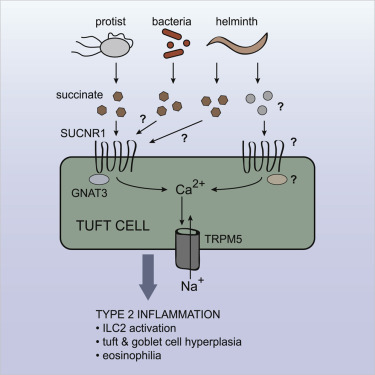

**N Tasks**
- MYC TARGETS V2
- MYC TARGETS V1
- KRAS SIGNALING DOWN
    - Here, we show that the IκB kinase (IKK)-related kinases Tank-binding kinase-1 (TBK1) and IKKε promote KRAS-driven tumorigenesis by regulating autocrine CCL5 and interleukin (IL)-6 and identify CYT387 as a potent JAK/TBK1/IKKε inhibitor. CYT387 treatment ablates RAS-associated cytokine signaling and impairs Kras-driven murine lung cancer growth. https://pubmed.ncbi.nlm.nih.gov/24444711/

**A2 Tasks**
- KRAS SIGNALING UP
- ESTROGEN RESPONSE LATE 
    - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC138722/
- ESTROGEN RESPONSE EARLY
- PI3K AKT MTOR SIGNALING

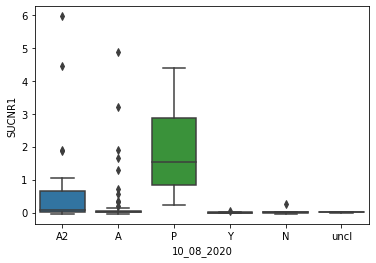

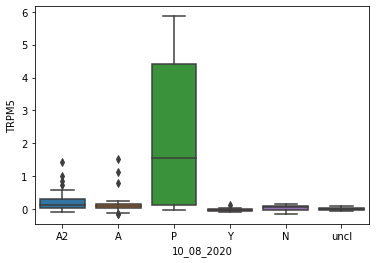

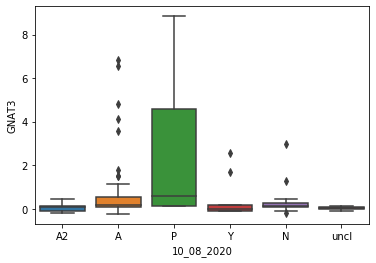

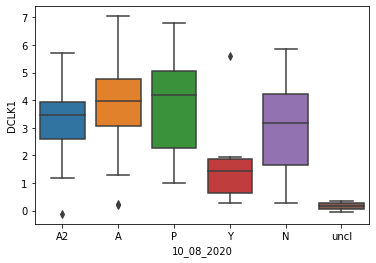

In [131]:
sns.boxplot(y=  data['SUCNR1'], x = clines['10_08_2020'],)
plt.show()
sns.boxplot(y=  data['TRPM5'], x = clines['10_08_2020'],)
plt.show()
sns.boxplot(y=  data['GNAT3'], x = clines['10_08_2020'],)
plt.show()
sns.boxplot(y=  data['DCLK1'], x = clines['10_08_2020'],)


## Mimicking different TMEs for task optimization

### Mesenchymal stem cells/ Bone Differentiation
https://www.frontiersin.org/articles/10.3389/fbioe.2017.00032/full#readcube-epdf

Bone marrow microenviroment is constituted by many diverse cell types, which establish an intense cross-talk among them. In particular, in recent years, MSCs have gained great attention for their trophic support to other cells, ability to secrete bioactive factors and plasticity, and for the possibility to be exploited in regenerative medicine applications. On the other hand, the out-come of much experimentation has failed to meet the forecasted expectations. The real challenge that still has to be faced is the global understanding of the cellular and molecular mechanisms, which take place in BM-ME and star MSCs as main character or as target.This review gives just a flavor of the variety of soluble factors provided by neighboring cells, by the ECM or by other tissues influencing MSCs properties in pathophysiological settings. Many of these factors may elicit opposite MSCs behavior depend-ing on the overall environmental conditions, as demonstrated by the controversial results reported in literature. Furthermore, the signaling pathways activated downstream each ligand/receptor interaction often intersect and then intertwine or diverge, thus generating an additional layer of complexity. The recent highlight on RANKL as a putative novel regulator of MSCs fate raises the possibility that additional factors involved in orchestrating MSCs functions have still to be recognized. A wider landscape of molecular and cellular interactions and of rules to be accom-plished or modified to elicit specific cell behaviors needs to be reached. This deep understanding will improve the capacity to manipulate BM-ME and to effectively use MSCs for cell therapy.
- RANKL
- Irisin can induce MSCs osteoblast differentiation through p38/ERK MAPK signaling pathways, leading to the upregulation of osteogenic marker genes, such as Atf4, Runx2, Osx, Lrp5, β-catenin, Alp, and Col1a1
- PTH is one of the principal modulator of calcium homeostasis through cAMP/PKA/PLCγ signaling. It also displays both catabolic and anabolic functions in bone remodeling: the former is exerted by inducing RANKL production, which fosters osteoclasts’ generation and activity, the latter by affecting MSCs fate (Hock and Gera, 1992; Qin et al., 2004). Indeed, PTH induces in vitro osteogenic differentiation via LRP6-dependent BMP/SMAD signaling (Polo and Di Fiore, 2006; Jilka, 2007; Qiu et al., 2010; Yu et al., 2012).

## Determining phenotypic movement by CyTOF

Similar to Akshata's experiment, we will use some CyTOF markers to say whether the cytokines have pushed cells towards one archetype or another (and compare to predictions from archetype tasks). 

Below, I am comparing the CyTOF panel to distance from each archetype.

In [133]:
cytof = ['ASCL1','CEACAM5',"CD24",'TTF1','YAP1','NEUROD1','HES1','THY1',
        'SYP','CD44','AKT1','RPS6','MYC','SOX1','NCAM1','EPCAM','KRT8',
         'CTNNB1','SOX2','STAT3','S100B','BMX','MKI67','MIB1','ITGA6','ATP1A1',
        'MAPK1','STAT6','GFAP','MET','PTPRC','UCHT1','CD4','CD19','CAS3',
         'PDGFRB','POU5F1','HLA-DRA','ITGAM']
# CD66E - CEACAM5
# CD24
# CD90 -THY1
# CD56 - NCAM1
# KI67
# CD49F - ITGA6
# CD298 - ATP1A1
# ERK - MAPK1
# CD45 - PTPRC
# CD3 - UCHT1
# CAS3
# MHC1 - H2K1
# OCT3 - POU5F1
# HLADR
# CD11B - ITGAM

In [134]:
from scipy.stats import pearsonr, spearmanr
cytof_markers = []
cytof_marker_subtype = []
cytof_corr = []
for subtype in sorted(distances):
    for m in cytof:
        try:
            corr, _ = pearsonr(distances[subtype], data[m])
            if -corr > .5:
                cytof_markers.append(m)
                cytof_marker_subtype.append(subtype)
                cytof_corr.append(corr)

        except KeyError: pass


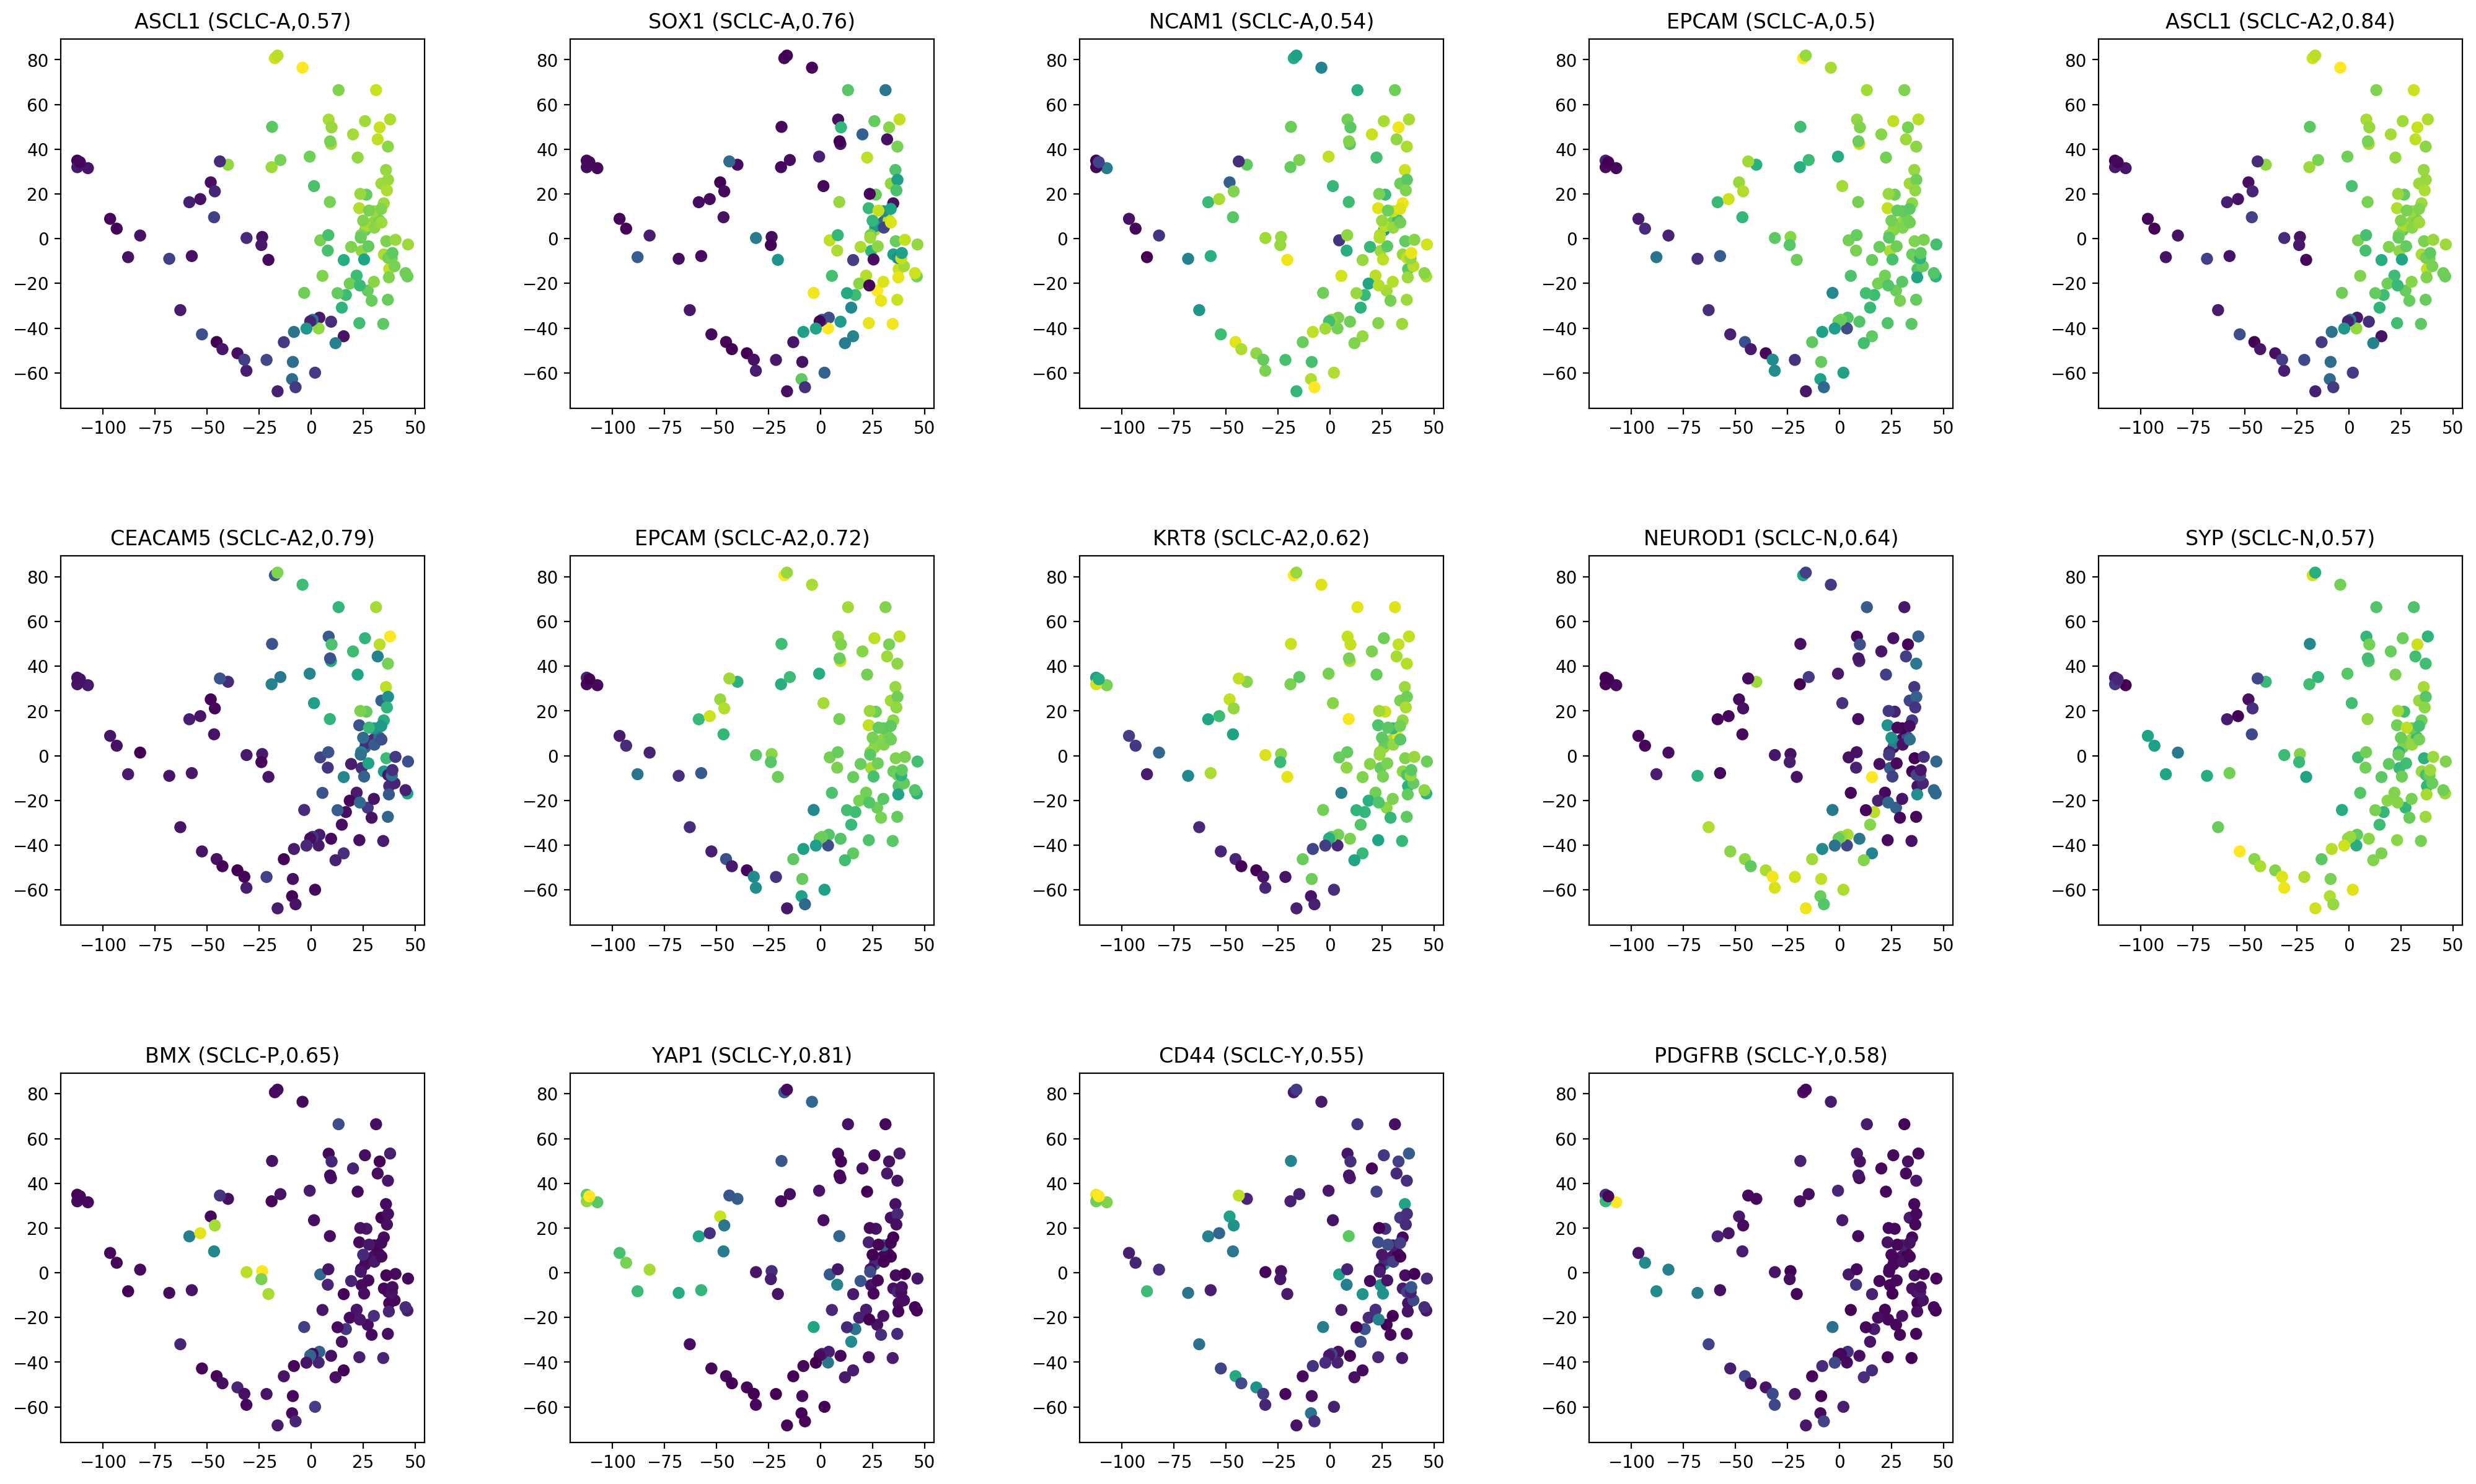

In [135]:
fig = plt.figure(figsize = (25,15), dpi = 200)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i,m in enumerate(cytof_markers):
    ax = fig.add_subplot(3, 5, i+1)
    ax.scatter(pcs[0],pcs[1], c = data[m], cmap='viridis')
    plt.title(m + " (" +cytof_marker_subtype[i] +f",{-np.round(cytof_corr[i],2)})")


We can use these genes in a similar way to our archetype signature: Together, they make a gene signature defined at each archetype. By comparing CyTOF results to the expected signature, we can place cells in this continuum (or at least relative to each archetype) and show that cells move closer to one phenotype or another and compare positive results to tasks.

In [136]:
cytof = arc.loc[cytof_markers] 

In [160]:
cytof.columns = ['SCLC-Y','SCLC-P','SCLC-N','SCLC-A2','SCLC-A']

In [161]:
(cytof.T>cytof.T.mean()).T

SCLC-Y  SCLC-P  SCLC-N  SCLC-A2  SCLC-A
ASCL1     False   False   False     True    True
SOX1      False   False   False     True    True
NCAM1     False   False    True     True    True
EPCAM     False    True   False     True    True
ASCL1     False   False   False     True    True
CEACAM5   False   False   False     True   False
EPCAM     False    True   False     True    True
KRT8      False    True   False     True    True
NEUROD1   False   False    True    False   False
SYP       False   False    True     True    True
BMX       False    True   False    False   False
YAP1       True    True   False    False   False
CD44       True    True   False    False   False
PDGFRB     True   False   False    False   False

## Experimental Design

### Materials

**Cell Lines**

We essentially want 2-3 cell lines at each archetype (as a baseline for drug response for that archetype) and at least 1, preferrably 2, between combinations of archetypes (P-Y intermediates, etc).
The CyTOF panel should be able to locate these in archetype space based on the overlap above between the archetype signatures and the panel.

- A: H2108, H1926
- A2: ***DMS53*, DMS153, *DMS454***
- N: ***H524***, H60
- P: **H211**, H526
- Y: **H196, *H841*,** SW1271
- Intermediate
   -  A-N: ***H69, CORL279***, CORL24, H378
   -  A-A2: **H889**
   -  N-Y: ***H82*, H446**
   -  P-Y: **H1607, *H1048*,** DMS114
   -  A2-P: H2066
   -  N-P: CORL311
   -  A-A2-Y: H2195
   -  Far from every archetype: H1341
   
Bold: CyTOF; Italics: scRNA-seq


**Perturbagens**

Things to kill cells by archetype task
1. Perturbagens expected to kill A cells preferrentially:
    1. Cell growth related perturbations
2. Perturbagens expected to kill A2 cells preferrentially:
2. Perturbagens expected to kill N cells preferrentially:
    1. AURK: microtubule assembly into mitotic spindles
2. Perturbagens expected to kill P cells preferrentially:
2. Perturbagens expected to kill Y cells preferrentially:
    1. IL2-STAT5?



Things to optimize the environment for a specific archetype task
1. **SCLC-Y: injury repair**
    1. Low-Dose IFNγ may push cells towards Y
    2. TGF-β1, TGF-β2, TGF-β3, MCP-1, BFGF, TNF-α, IL-1β
    3. TNFA should push SCLC-Y to NE
    4. EZH2, TGFB
    5. IL6
    6. VEGF
2. **SCLC-A: hypoxia induced proliferation**
    1.  Hypoxia response (?) HIF1A
3. **SCLC-A2: secretion/endocrine function and immune regulation**
4. **SCLC-N: Migratory/slithering**
    1. motogens
    2. C-C chemokines (RANTES, monocyte chemoattractant protein or MCP-1, monocyte inflammatory protein or MIP-1α, and MIP-1β), C-X-C chemokines (IL-8 also called growth related oncogene or GRO/KC), C chemokines (lymphotactin), and CXXXC chemokines (fractalkine)
5. **SCLC-P: chemosensory/dysregulated metabolism**
    1. ROS: AAPH
    2. Dietary succinate and perturbations in the microbiota activate tuft cells
    3. CO2 balance, hypoxia, etc.
6. **Environments outside of the Archetype space**
    1. Bone: RANKL
    2. PTH




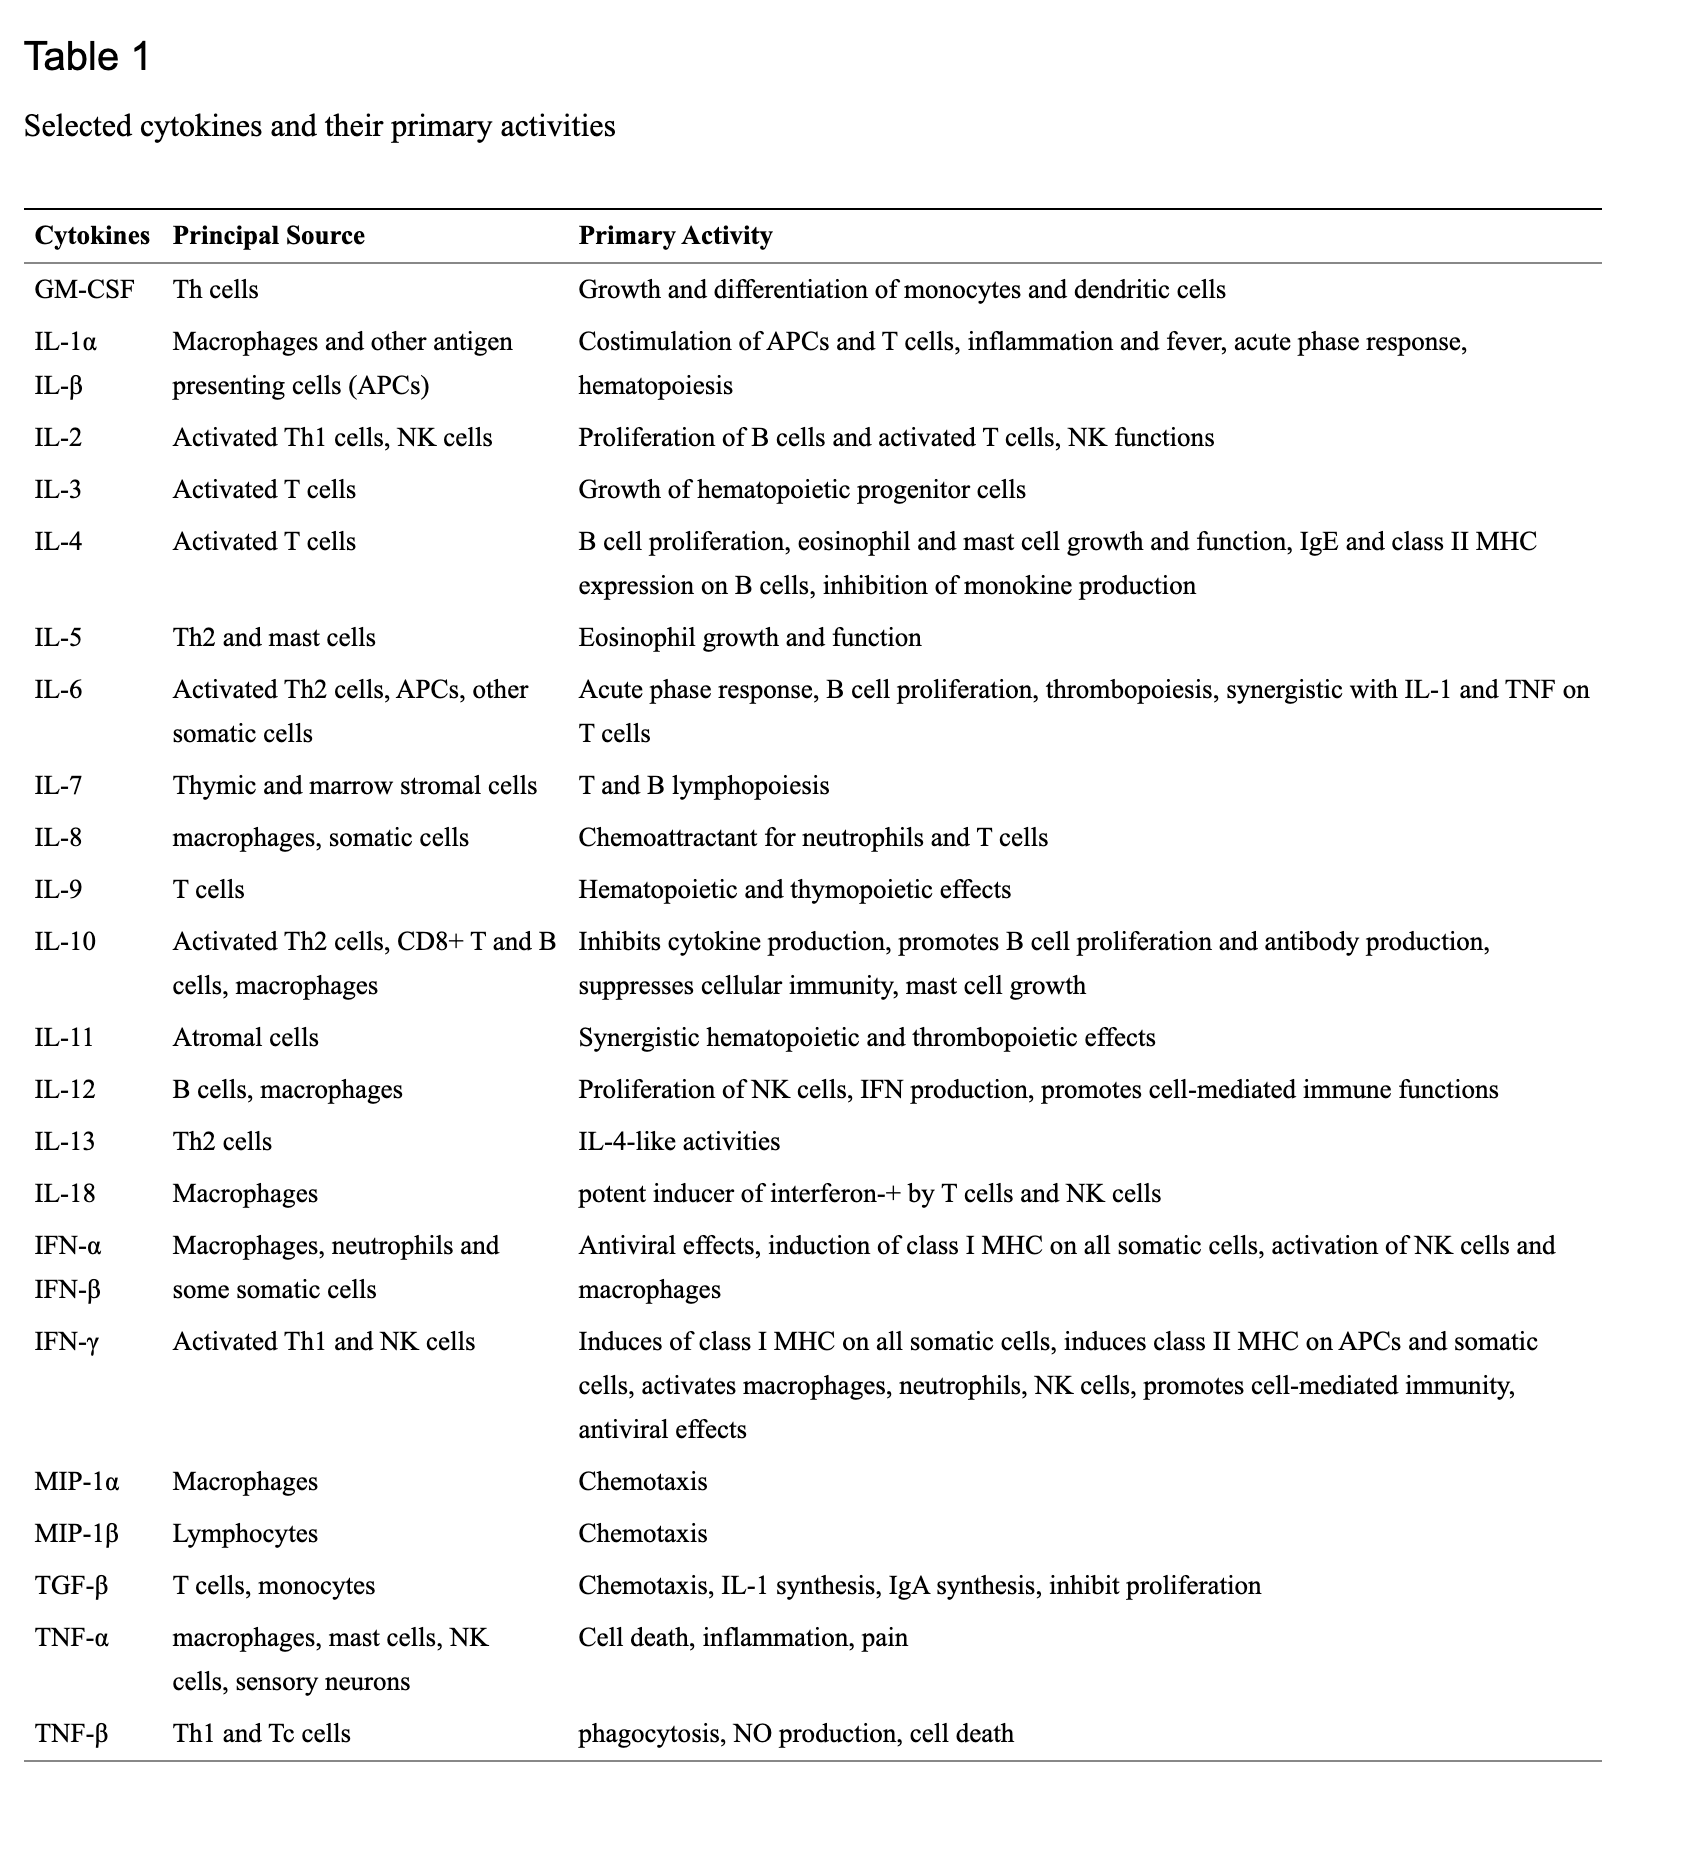

### Methods

We essentially want to do a higher throughput version of Akshata's experiments below:

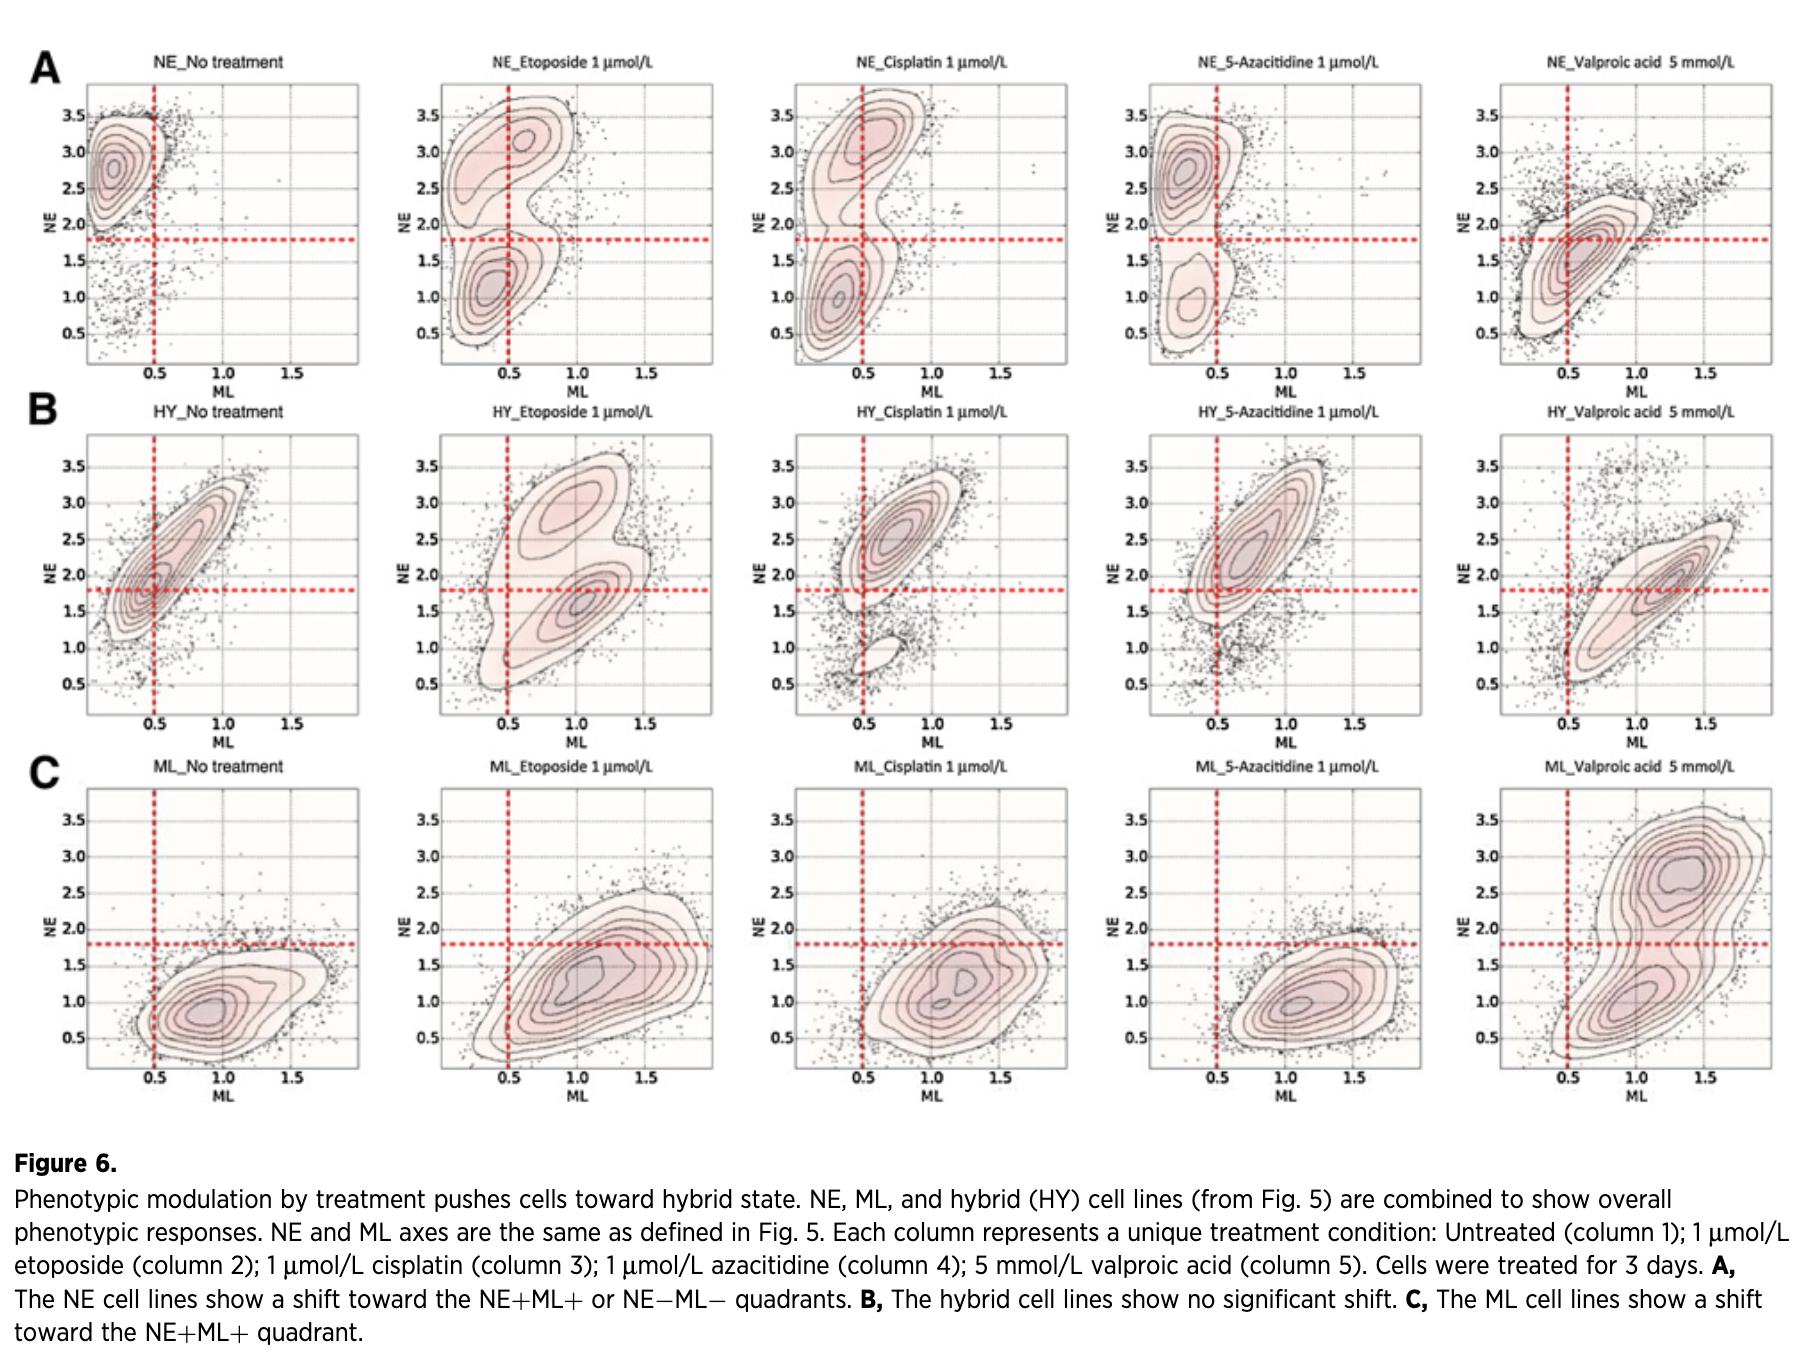

## Expected Results

# Ability to traverse the continuum could be strictly linked to recalcitrant properties, ability to adapt to metastatic microenvironment, or resistance to therapy


These experiments would be best performed in different microenvironments, to show how generalists vs specialists fare.

# MYC is capable of influencing the distribution of SCLC cell states by increasing CTrP in neuroendocrine specialists


Based on this plasticity analysis of RPM tumor cells, we conclude that MYC was capable of influencing the distribution of SCLC cell states by increasing CTrP in neuroendocrine specialists
